# Environnement

# Set up

In [1]:
!which python


/opt/anaconda3/envs/Model2/bin/python


In [2]:
#!pip install -r ./requirements_modelling.txt
#!pip install -r ../common_requirements.txt

In [3]:
#!pip install imbalanced-learn

In [4]:
!python -m pip list

Package                            Version
---------------------------------- -----------
alembic                            1.14.0
annotated-types                    0.7.0
anyio                              4.6.2
appdirs                            1.4.4
appnope                            0.1.3
argon2-cffi                        21.3.0
argon2-cffi-bindings               21.2.0
asttokens                          2.0.5
async-lru                          2.0.4
attrs                              24.2.0
Babel                              2.11.0
beautifulsoup4                     4.12.3
bleach                             4.1.0
blinker                            1.8.2
Brotli                             1.0.9
cachetools                         5.5.0
certifi                            2024.8.30
cffi                               1.17.1
charset-normalizer                 3.3.2
click                              8.1.7
cloudpickle                        3.1.0
comm                               0.2

In [5]:
pip list()

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `/opt/anaconda3/envs/Model2/bin/python -m pip list()'
Note: you may need to restart the kernel to use updated packages.


Python librairies imports :

In [6]:
!pip list | grep -E 'hyperopt|xgboost|lime|shap|evidently'

evidently                          0.4.39
hyperopt                           0.2.7
lime                               0.2.0.1
shap                               0.46.0
xgboost                            2.1.2


In [7]:
#!pip install dill numpy pandas scikit-learn hyperopt xgboost lightgbm imbalanced-learn lime shap evidently matplotlib seaborn

In [8]:
#!pip install ipywidgets --upgrade


In [9]:
# File system management
import os
import pickle
import dill

from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler 

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials 
from hyperopt.pyll.base import scope

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as ltb

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular
import shap

# Data drift
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(palette="Set1")

# import data 

In [10]:
# Load data
data = pd.read_csv("../data/processed/train_feature_engineering_sample.csv")
data_test = pd.read_csv("../data/processed/test_feature_engineering_sample.csv")

In [11]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,104589.0,0.0,0,0,1,0,0,135000.0,133659.0,12388.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,223615.0,0.0,0,1,0,0,2,110250.0,472500.0,44991.0,...,False,True,0.0125,1.0,0.0125,False,False,0.0,0.0,0.0
2,315031.0,0.0,0,1,0,1,2,117000.0,675000.0,28728.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,130862.0,0.0,0,0,1,0,0,135000.0,592560.0,32274.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140528.0,0.0,0,1,1,0,1,180000.0,715095.0,48109.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
data_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,218796.0,0,1,0,0,0,103500.0,280170.0,29547.0,0.018029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202006.0,0,1,0,0,1,202500.0,383787.0,33070.5,0.018850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123688.0,0,1,0,0,1,157500.0,440784.0,34956.0,0.002134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,389440.0,0,1,0,0,0,90000.0,189000.0,12757.5,0.015221,...,False,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0
4,166255.0,0,1,0,0,0,135000.0,450000.0,19197.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Functions

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, fbeta_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Function to display the confusion matrix
# y_true : array-like of shape (n_samples,) - True labels of the data
# y_pred : array-like of shape (n_samples,) - Predicted labels from the model
# model_name : str - Name of the model for which the confusion matrix is displayed
def display_confusion_matrix(y_true, y_pred, model_name):
    # Compute the confusion matrix and unravel it into four main components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Print the model name for which the confusion matrix is displayed
    print(f"Matrice de confusion pour {model_name} :")
    # Print the individual components of the confusion matrix: true negative, false positive, false negative and true positive
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    # Print a new line for better readability
    print("\n")

In [15]:
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Calculate necessary metrics for the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Calculate false positive rates, true positive rates, and thresholds
    auc = roc_auc_score(y_test, y_pred_proba)  # Calculate the Area Under Curve (AUC)
    
    # Create a new figure to plot the curve
    plt.figure()
    plt.title(model_name + ": ROC curve")  # Add a title to the ROC curve

    # Plot the reference line y=x (baseline)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')  # Dashed line as baseline

    # Plot the actual ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format(auc))  # Add the legend with the AUC value

    if disp_best_th:
        # Calculate the best threshold based on the minimum distance to (0,1)
        o_tpr = tpr[np.argmin(np.abs(fpr + tpr - 1))]  # Optimal true positive rate
        o_fpr = fpr[np.argmin(np.abs(fpr + tpr - 1))]  # Optimal false positive rate
        o_threshold = thresholds[np.argmin(np.abs(fpr + tpr - 1))]  # Optimal threshold

        # Display the optimal threshold point on the ROC curve
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))  # Add a point for the best threshold

    plt.ylabel('True Positive Rate')  # Label the y-axis
    plt.xlabel('False Positive Rate')  # Label the x-axis
    plt.legend(loc=4)  # Place the legend
    plt.show()  # Display the plot

    return auc  # Return the AUC score to evaluate model performance

The AUC score is a valuable metric for evaluating the performance of a binary classification model, especially when dealing with imbalanced datasets. It provides a single scalar value that summarizes the model's ability to discriminate between the positive and negative classes across all possible threshold values.

In [16]:
# La fonction `compute_classification_results` a pour objectif de calculer les résultats de classification
# 
# Elle est utile dans le cadre de ce projet car elle compile plusieurs métriques de performance clés qui 
# permettent d'analyser la qualité du modèle sur les données de test.

# 1. **Prédictions de Probabilité :** Elle calcule la probabilité que chaque instance appartienne à la classe positive 
#    (classe 1) à l'aide de la méthode `predict_proba`. Cette étape est cruciale pour des mesures telles que la courbe ROC.
# 
# 2. **Prédictions de Classes :** Elle produit les étiquettes de classe en utilisant la méthode `predict`.
# 
# 3. **Matrice de Confusion :** La fonction affiche une matrice de confusion pour visualiser les résultats, 
#    en montrant les vrais positifs (TP), faux positifs (FP), vrais négatifs (TN) et faux négatifs (FN).
# 
# 4. **Courbe ROC et AUC :** Elle trace la courbe ROC et calcule l'aire sous la courbe (AUC), ce qui donne un indicateur 
#    de la capacité du modèle à classer correctement les instances entre les deux classes.
# 
# 5. **Rapport de Classification :** Un rapport de classification est généré pour fournir des mesures telles que 
#    la précision, le rappel et le score F1 pour chaque classe.
# 
# 6. **F-beta Score :** Elle calcule le score F-beta, une généralisation du score F1 qui permet de pondérer 
#    l'importance relative de la précision et du rappel avec le paramètre beta.

In [17]:
def compute_classification_results(model, model_name, x_test, y_test, beta=2, disp_best_th=False):
    # Predict the probability of the positive class (e.g., defaulting on a loan)
    y_pred_proba = model.predict_proba(x_test)[:,1]

    # Predict the class labels for the test data
    y_pred = model.predict(x_test)

    # Display the confusion matrix to illustrate true vs. predicted labels
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Plot the ROC curve and calculate the AUC score to evaluate model performance
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name, disp_best_th=disp_best_th)

    # Generate a classification report with metrics such as precision, recall, and F1-score
    classification_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(classification_report)

    # Calculate the F-beta score, emphasizing recall over precision when beta > 1
    fbeta = fbeta_score(y_test, y_pred, beta=beta)
    print(f"F-beta score (beta={beta}) =", fbeta)

    # Return the computed performance metrics
    return fbeta, auc_score, classification_report

In [18]:
# Function to extract the best model from Hyperopt optimization trials
def trials_best_model(trials):
    # Filter the trials to include only those with a successful status
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    
    # Extract loss values from valid trials and convert them to float
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    
    # Identify the index of the trial with the minimum loss value
    min_loss_idx = np.argmin(losses)
    
    # Retrieve the trial object corresponding to the best (minimum loss) result
    best_trial_obj = valid_trial_list[min_loss_idx]
    
    # Print the loss value of the best trial for reference
    print("Best result :", best_trial_obj['result']['loss'])
    
    # Return the model associated with the best trial
    return best_trial_obj['result']['model']

# MLFlow

MLflow est utilisé pour suivre et enregistrer les résultats d'entraînement de modèles de machine learning. 

MLflow est un outil de gestion du cycle de vie des modèles, qui permet de logger (enregistrer) des hyperparamètres, des métriques,

des artefacts (comme les modèles eux-mêmes) et
d'autres informations pertinentes pour le suivi des expériences de machine learning.

Set up of MLFlow tracking.

In [19]:
%%capture captured_output
#!pip install mlflow


In [20]:
import mlflow
print(f"MLflow version: {mlflow.__version__}")


MLflow version: 2.16.2


La fonction log_mlflow est conçue pour enregistrer les paramètres, les métriques, et le modèle dans l'environnement MLflow.

In [21]:
#!pip install pyarrow==17.0.0


In [22]:
# Defines where to register the MLflow logs
mlflow.set_tracking_uri("../mlruns")

In [23]:
# Define the name of the MLflow experiment
defined_name = 'credit_scoring'

# Set up the experiment. This will create a new experiment if one doesn't exist with this name already.
mlflow.set_experiment(defined_name)

# Start a new run to log parameters and metrics under the defined experiment
with mlflow.start_run() as run:
    # Log parameters. Here, 'param1' is a placeholder for any parameter you want to track, and '5' is its value.
    mlflow.log_param("param1", 5)
    
    # Log metrics. 'metric1' is a name given to the metric, and '0.89' is its value, representing model performance.
    mlflow.log_metric("metric1", 0.89)

# The run is ended automatically after exiting the 'with' block, ensuring all logged data is saved.


Traceback (most recent call last):
  File "/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
        

In [24]:
# Function to log model to mlflow
def log_mlflow(model, name, custom_score, n_estimator=None, max_depth=None, auc_score=None, f1_score=None, acc_score=None,
               train_class_0=None, train_class_1=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

#mlflow ui


In [25]:
# Checks if experimentation was effectively created
print("Expérimentation définie :", mlflow.get_experiment_by_name("credit_scoring"))


Traceback (most recent call last):
  File "/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
        

Expérimentation définie : <Experiment: artifact_location='/Users/laureagrech/Desktop/oc7_streamlit/streamlit_dashboard/notebooks/../mlruns/868099090215055578', creation_time=1730942517786, experiment_id='868099090215055578', last_update_time=1730942517786, lifecycle_stage='active', name='credit_scoring', tags={}>


# Data preparation

In [26]:
"""# Define target and features
TARGET = 'TARGET'
target = data[TARGET].to_numpy()
features = data.drop(columns=TARGET).to_numpy()
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42"""

"# Define target and features\nTARGET = 'TARGET'\ntarget = data[TARGET].to_numpy()\nfeatures = data.drop(columns=TARGET).to_numpy()\nfeatures_names = data.drop(columns=TARGET).columns.to_list()\n\n# Define training set size\nTRAIN_SIZE = 0.8\n\n# Define random state\nRANDOM_STATE = 42"

## Missing values

In [27]:
"""# Check missing values
nan_values = data.isna().sum().sum()
print("Missing values = {} ({:.2%})".format(nan_values, nan_values/data.size))"""

'# Check missing values\nnan_values = data.isna().sum().sum()\nprint("Missing values = {} ({:.2%})".format(nan_values, nan_values/data.size))'

I fill the missing values with a simple imputer.

In [28]:
"""# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit to data
imp_mean.fit(features)

# Transform data
features_fill = imp_mean.transform(features)"""

"# Create imputer\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\n\n# Fit to data\nimp_mean.fit(features)\n\n# Transform data\nfeatures_fill = imp_mean.transform(features)"

## Split data

I split the data into training and testing sets.

In [29]:
"""# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)"""

'# Split dataset (filled)\nx_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)'

In [30]:
"""# Define stratifiedKfold
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)"""

'# Define stratifiedKfold\nstrat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)'

## Balance data

In [31]:
"""y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
print("Testing target statistics:", Counter(y_test))

# Print ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))"""

'y_train_counter = Counter(y_train)\nprint("Training target statistics:", y_train_counter)\nprint("Testing target statistics:", Counter(y_test))\n\n# Print ratio\nprint("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))'

I will define a pipeline that first transforms the training dataset with SMOTE then fits the model.

In [32]:
"""# Define oversampling and undersampling
oversampling = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
undersampling = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('oversampling', oversampling), ('undersampling', undersampling)]
# steps = [('over', over)]

pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)
#fit_resample prend les données dentraînement (x_train, y_train) comme entrée.
#Il applique d'abord SMOTE pour suréchantillonner la classe minoritaire.
#Ensuite, il applique RandomUnderSampler pour réduire le nombre d'exemples de la classe majoritaire."""
"""
print("Training target statistics:", Counter(y_res)) # Statistiques après rééchantillonnage
print("Testing target statistics:", Counter(y_test)) # Statistiques du jeu de test"""

'\nprint("Training target statistics:", Counter(y_res)) # Statistiques après rééchantillonnage\nprint("Testing target statistics:", Counter(y_test)) # Statistiques du jeu de test'

In [33]:
"""print("Training target statistics:", Counter(y_res)) 
print("Testing target statistics:", Counter(y_test)) # Statistiques du jeu de test"""


'print("Training target statistics:", Counter(y_res)) \nprint("Testing target statistics:", Counter(y_test)) # Statistiques du jeu de test'

In [34]:
"""# Display barplot of distribution to see Smote impact on data
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title("Target distribution")
plt.show()"""

'# Display barplot of distribution to see Smote impact on data\nclass_distr_df = pd.DataFrame({\'training set\': [\'unbalanced\', \'unbalanced\', \'balanced\', \'balanced\'],\n                               \'target\': [\'Class 0\', \'Class 1\', \'Class 0\', \'Class 1\'],\n                               \'count\': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})\n\n# Display barplot\nsns.barplot(class_distr_df, x=\'training set\', y=\'count\', hue=\'target\')\nplt.title("Target distribution")\nplt.show()'

## Custom loss function

Rule : cost FN (dont repay - predicted as repay) = 10 cost FP (repay - predicted as dont repay)

Le make scorer fonctionne bien pour calculer un score métier en se basant sur la matrice de confusion, avec une pénalisation spécifique pour les faux négatifs.

On adapte le paramètre beta pour le F-beta score dans make_scorer. 

Le F-beta score permet de donner plus ou moins d'importance au Recall (sensibilité) ou à la Précision, selon la valeur de beta.

### avec beta score

In [35]:
from sklearn.metrics import fbeta_score

# with beta = 2 more importance is given to the Recall
# Function to calculate the F-beta score with an adjested beta
def fbeta_scorer(beta=2):
    return make_scorer(fbeta_score, beta=beta)

a custom scorer function using the make_scorer utility from the sklearn.metrics module in scikit-learn. 

This custom scorer is designed to calculate the F-beta score, a metric that balances precision and recall, with an adjustable beta parameter to give more importance to recall.

# ML Flow models tracking

In [36]:
import os
import time
import pandas as pd
import joblib
import mlflow
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

def train_and_log_model(model, model_name, data, target_name='TARGET', train_size=0.8, random_state=42, betas=[0.5, 1, 2, 2.5]):
    # Separate the target from the data and convert it to a NumPy array
    target = data[target_name].to_numpy()
    
    # Remove the target column from the data and convert the rest to a NumPy array
    features = data.drop(columns=target_name).to_numpy()

    # Split the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)

    # Create a preprocessing pipeline
    preprocess_pipeline = ImbPipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('oversampling', SMOTE(sampling_strategy=0.5, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=1, random_state=random_state)),
        ('model', model)
    ])

    # Initialize a list to store the results
    results = []
    
    # Loop over each beta value to calculate the F-beta score
    for beta in betas:
        # Start the timer for this beta value
        start_time = time.time()
        
        # Start a new MLflow run to log the parameters and metrics
        with mlflow.start_run(run_name=f"{model_name}_beta_{beta}"):
            
            # Train the preprocessing pipeline on the training data
            preprocess_pipeline.fit(x_train, y_train)
            
            # Make predictions on the test set
            y_pred = preprocess_pipeline.predict(x_test)
            # Predict probabilities for the positive class
            y_pred_proba = preprocess_pipeline.predict_proba(x_test)[:, 1]

            # Calculate accuracy, AUC score, and F-beta score
            accuracy = accuracy_score(y_test, y_pred)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            fbeta = fbeta_score(y_test, y_pred, beta=beta)
            
            # Generate a classification report
            clf_report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

            # Calculate the duration for this beta value
            duration = time.time() - start_time

            # Log the model parameters and calculated metrics in MLflow
            mlflow.log_params({"model_type": model_name, "beta": beta})
            mlflow.log_metrics({
                "accuracy": accuracy,
                "AUC": auc_score,
                "F-beta": fbeta,
                "training_duration_seconds": duration  
            })

            # Add the results for the current beta to the list
            results.append({
                'Beta': beta,
                'AUC': auc_score,
                'Accuracy': accuracy,
                'F-beta': fbeta,
                'Report': clf_report,
                'Duration': duration  
            })

            # Set the path to save the trained model
            #model_path = f'../models/{model_name}_beta_{beta}_pipeline.pkl'
            # Save the preprocessing pipeline and the model to the specified path
            #joblib.dump(preprocess_pipeline, model_path)
            # Log the artifact of the saved model in MLflow
            #mlflow.log_artifact(model_path)

    # Return the complete list of results
    return results


## DummyClassifier

In [37]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='stratified', random_state=42)
model_name = 'DummyClassifier'


results = train_and_log_model(
    model=model,
    model_name=model_name,
    data=data,  
    target_name='TARGET',
    betas=[0.5, 1, 2, 2.5]
)

In [38]:
for result in results:
    beta = result['Beta']
    auc_score = result['AUC']
    accuracy = result['Accuracy']
    fbeta = result['F-beta']
    clf_report = result['Report']
    
    # Convert the classification report to a DataFrame
    clf_report_df = pd.DataFrame(clf_report).transpose()
    
    # Handle the 'accuracy' row separately
    if 'accuracy' in clf_report_df.index:
        overall_accuracy = clf_report_df.loc['accuracy', 'precision']
        clf_report_df = clf_report_df.drop('accuracy')
    else:
        overall_accuracy = accuracy  # If 'accuracy' is not in the report
    
    clf_report_df['support'] = clf_report_df['support'].astype(int)
    
    # Display the results
    print(f"\nResults for {model_name} with beta = {beta}:")
    print(f"AUC: {auc_score:.6f}")
    print(f"Accuracy: {accuracy:.6f}")
    print(f"F-beta: {fbeta:.6f}")
    print(f"Overall Accuracy from report: {overall_accuracy:.6f}")
    print("Classification Report:")
    display(clf_report_df)



Résultats pour DummyClassifier avec beta = 0.5:
AUC: 0.522605
Accuracy: 0.505446
F-beta: 0.105538
Overall Accuracy from report: 0.505446
Classification Report:


,precision,recall,f1-score,support
0.0,0.925636,0.502123,0.651067,5652
1.0,0.087844,0.543086,0.151228,499
macro avg,0.506740,0.522605,0.401147,6151
weighted avg,0.857670,0.505446,0.610517,6151



Résultats pour DummyClassifier avec beta = 1:
AUC: 0.522605
Accuracy: 0.505446
F-beta: 0.151228
Overall Accuracy from report: 0.505446
Classification Report:


,precision,recall,f1-score,support
0.0,0.925636,0.502123,0.651067,5652
1.0,0.087844,0.543086,0.151228,499
macro avg,0.506740,0.522605,0.401147,6151
weighted avg,0.857670,0.505446,0.610517,6151



Résultats pour DummyClassifier avec beta = 2:
AUC: 0.522605
Accuracy: 0.505446
F-beta: 0.266680
Overall Accuracy from report: 0.505446
Classification Report:


,precision,recall,f1-score,support
0.0,0.925636,0.502123,0.651067,5652
1.0,0.087844,0.543086,0.151228,499
macro avg,0.506740,0.522605,0.401147,6151
weighted avg,0.857670,0.505446,0.610517,6151



Résultats pour DummyClassifier avec beta = 2.5:
AUC: 0.522605
Accuracy: 0.505446
F-beta: 0.316704
Overall Accuracy from report: 0.505446
Classification Report:


,precision,recall,f1-score,support
0.0,0.925636,0.502123,0.651067,5652
1.0,0.087844,0.543086,0.151228,499
macro avg,0.506740,0.522605,0.401147,6151
weighted avg,0.857670,0.505446,0.610517,6151


## Logistic Regression

In [39]:
mlflow.end_run()

In [40]:
model = LogisticRegression(solver='liblinear', random_state=42)
model_name = 'LogisticRegression'

# Load the data (make sure 'data' is defined)
# data = pd.read_csv('your_dataset.csv')

# Execute the function
results = train_and_log_model(
    model=model,
    model_name=model_name,
    data=data,
    target_name='TARGET',
    betas=[0.5, 1, 2, 2.5]
)

# Display the results
for result in results:
    beta = result['Beta']
    auc_score = result['AUC']
    accuracy = result['Accuracy']
    fbeta = result['F-beta']
    clf_report = result['Report']
    
    # Convert the classification report to a DataFrame
    clf_report_df = pd.DataFrame(clf_report).transpose()
    
    # Handle the 'accuracy' row separately
    if 'accuracy' in clf_report_df.index:
        overall_accuracy = clf_report_df.loc['accuracy', 'precision']
        clf_report_df = clf_report_df.drop('accuracy')
    else:
        overall_accuracy = accuracy  # If 'accuracy' is not in the report
    
    clf_report_df['support'] = clf_report_df['support'].astype(int)
    
    # Display the results
    print(f"\nResults for {model_name} with beta = {beta}:")
    print(f"AUC: {auc_score:.6f}")
    print(f"Accuracy: {accuracy:.6f}")
    print(f"F-beta: {fbeta:.6f}")
    print(f"Overall Accuracy from report: {overall_accuracy:.6f}")
    print("Classification Report:")
    display(clf_report_df)



Résultats pour LogisticRegression avec beta = 0.5:
AUC: 0.713281
Accuracy: 0.705739
F-beta: 0.182031
Overall Accuracy from report: 0.705739
Classification Report:


,precision,recall,f1-score,support
0.0,0.952000,0.715853,0.817209,5652
1.0,0.155181,0.591182,0.245833,499
macro avg,0.553591,0.653518,0.531521,6151
weighted avg,0.887358,0.705739,0.770856,6151



Résultats pour LogisticRegression avec beta = 1:
AUC: 0.713281
Accuracy: 0.705739
F-beta: 0.245833
Overall Accuracy from report: 0.705739
Classification Report:


,precision,recall,f1-score,support
0.0,0.952000,0.715853,0.817209,5652
1.0,0.155181,0.591182,0.245833,499
macro avg,0.553591,0.653518,0.531521,6151
weighted avg,0.887358,0.705739,0.770856,6151



Résultats pour LogisticRegression avec beta = 2:
AUC: 0.713281
Accuracy: 0.705739
F-beta: 0.378496
Overall Accuracy from report: 0.705739
Classification Report:


,precision,recall,f1-score,support
0.0,0.952000,0.715853,0.817209,5652
1.0,0.155181,0.591182,0.245833,499
macro avg,0.553591,0.653518,0.531521,6151
weighted avg,0.887358,0.705739,0.770856,6151



Résultats pour LogisticRegression avec beta = 2.5:
AUC: 0.713281
Accuracy: 0.705739
F-beta: 0.426067
Overall Accuracy from report: 0.705739
Classification Report:


,precision,recall,f1-score,support
0.0,0.952000,0.715853,0.817209,5652
1.0,0.155181,0.591182,0.245833,499
macro avg,0.553591,0.653518,0.531521,6151
weighted avg,0.887358,0.705739,0.770856,6151


In [41]:
mlflow.end_run()

## Random Forest

In [42]:
import os
import time
import pandas as pd
import joblib
import mlflow
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

# Training and logging the Random Forest model
model = RandomForestClassifier(random_state=42)
model_name = 'RandomForest'

# Run the function for the Random Forest model
results = train_and_log_model(
    model=model,
    model_name=model_name,
    data=data,  # dataframe with the target and features
    target_name='TARGET',
    betas=[0.5, 1, 2, 2.5]
)

# Display the results for each beta
for result in results:
    beta = result['Beta']
    auc_score = result['AUC']
    accuracy = result['Accuracy']
    fbeta = result['F-beta']
    clf_report = result['Report']

    # Convert report into a dataframe
    clf_report_df = pd.DataFrame(clf_report).transpose()

    # Accuracy line separately
    if 'accuracy' in clf_report_df.index:
        overall_accuracy = clf_report_df.loc['accuracy', 'precision']
        clf_report_df = clf_report_df.drop('accuracy')
    else:
        overall_accuracy = accuracy

    clf_report_df['support'] = clf_report_df['support'].astype(int)

    # Display of the results
    print(f"\nRésultats pour {model_name} avec beta = {beta}:")
    print(f"AUC: {auc_score:.6f}")
    print(f"Accuracy: {accuracy:.6f}")
    print(f"F-beta: {fbeta:.6f}")
    print(f"Overall Accuracy from report: {overall_accuracy:.6f}")
    print("Classification Report:")
    display(clf_report_df)


Résultats pour RandomForest avec beta = 0.5:
AUC: 0.699945
Accuracy: 0.914648
F-beta: 0.150943
Overall Accuracy from report: 0.914648
Classification Report:


,precision,recall,f1-score,support
0.0,0.921836,0.991154,0.955239,5652
1.0,0.324324,0.048096,0.083770,499
macro avg,0.623080,0.519625,0.519504,6151
weighted avg,0.873363,0.914648,0.884541,6151



Résultats pour RandomForest avec beta = 1:
AUC: 0.699945
Accuracy: 0.914648
F-beta: 0.083770
Overall Accuracy from report: 0.914648
Classification Report:


,precision,recall,f1-score,support
0.0,0.921836,0.991154,0.955239,5652
1.0,0.324324,0.048096,0.083770,499
macro avg,0.623080,0.519625,0.519504,6151
weighted avg,0.873363,0.914648,0.884541,6151



Résultats pour RandomForest avec beta = 2:
AUC: 0.699945
Accuracy: 0.914648
F-beta: 0.057971
Overall Accuracy from report: 0.914648
Classification Report:


,precision,recall,f1-score,support
0.0,0.921836,0.991154,0.955239,5652
1.0,0.324324,0.048096,0.083770,499
macro avg,0.623080,0.519625,0.519504,6151
weighted avg,0.873363,0.914648,0.884541,6151



Résultats pour RandomForest avec beta = 2.5:
AUC: 0.699945
Accuracy: 0.914648
F-beta: 0.054498
Overall Accuracy from report: 0.914648
Classification Report:


,precision,recall,f1-score,support
0.0,0.921836,0.991154,0.955239,5652
1.0,0.324324,0.048096,0.083770,499
macro avg,0.623080,0.519625,0.519504,6151
weighted avg,0.873363,0.914648,0.884541,6151


In [43]:
mlflow.end_run()

## XGBoost

In [44]:
import os
import time
import pandas as pd
import joblib
import mlflow
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier# Importation des bibliothèques nécessaires
import os
import time
import pandas as pd
import joblib
import mlflow
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier




# Define the XGBoost model
model = XGBClassifier(eval_metric='logloss', random_state=42)
model_name = 'XGBoost'

# Run the function for XGBoost
results = train_and_log_model(
    model=model,
    model_name=model_name,
    data=data,  # data is the dataframe with the 'TARGET' column
    target_name='TARGET',
    betas=[0.5, 1, 2, 2.5]
)

# Results for each beta
for result in results:
    beta = result['Beta']
    auc_score = result['AUC']
    accuracy = result['Accuracy']
    fbeta = result['F-beta']
    clf_report = result['Report']

    # Convert the classification report to a DataFrame
    clf_report_df = pd.DataFrame(clf_report).transpose()

    # Display the accuracy line separately
    if 'accuracy' in clf_report_df.index:
        overall_accuracy = clf_report_df.loc['accuracy', 'precision']
        clf_report_df = clf_report_df.drop('accuracy')
    else:
        overall_accuracy = accuracy

    clf_report_df['support'] = clf_report_df['support'].astype(int)

    # Display the results
    print(f"\nRésultats pour {model_name} avec beta = {beta}:")
    print(f"AUC: {auc_score:.6f}")
    print(f"Accuracy: {accuracy:.6f}")
    print(f"F-beta: {fbeta:.6f}")
    print(f"Overall Accuracy from report: {overall_accuracy:.6f}")
    print("Classification Report:")
    display(clf_report_df)



Résultats pour XGBoost avec beta = 0.5:
AUC: 0.715551
Accuracy: 0.898065
F-beta: 0.220729
Overall Accuracy from report: 0.898065
Classification Report:


,precision,recall,f1-score,support
0.0,0.926933,0.965145,0.945653,5652
1.0,0.259398,0.138277,0.180392,499
macro avg,0.593166,0.551711,0.563023,6151
weighted avg,0.872779,0.898065,0.883571,6151



Résultats pour XGBoost avec beta = 1:
AUC: 0.715551
Accuracy: 0.898065
F-beta: 0.180392
Overall Accuracy from report: 0.898065
Classification Report:


,precision,recall,f1-score,support
0.0,0.926933,0.965145,0.945653,5652
1.0,0.259398,0.138277,0.180392,499
macro avg,0.593166,0.551711,0.563023,6151
weighted avg,0.872779,0.898065,0.883571,6151



Résultats pour XGBoost avec beta = 2:
AUC: 0.715551
Accuracy: 0.898065
F-beta: 0.152520
Overall Accuracy from report: 0.898065
Classification Report:


,precision,recall,f1-score,support
0.0,0.926933,0.965145,0.945653,5652
1.0,0.259398,0.138277,0.180392,499
macro avg,0.593166,0.551711,0.563023,6151
weighted avg,0.872779,0.898065,0.883571,6151



Résultats pour XGBoost avec beta = 2.5:
AUC: 0.715551
Accuracy: 0.898065
F-beta: 0.147795
Overall Accuracy from report: 0.898065
Classification Report:


,precision,recall,f1-score,support
0.0,0.926933,0.965145,0.945653,5652
1.0,0.259398,0.138277,0.180392,499
macro avg,0.593166,0.551711,0.563023,6151
weighted avg,0.872779,0.898065,0.883571,6151


In [45]:
mlflow.end_run()

## Light Gbm

In [46]:
# Importation des bibliothèques nécessaires
import os
import time
import pandas as pd
import joblib
import mlflow
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier



# Définition du modèle LightGBM
model = LGBMClassifier(random_state=42)
model_name = 'LightGBM'

# Exécution de la fonction pour LightGBM
results = train_and_log_model(
    model=model,
    model_name=model_name,
    data=data, 
    target_name='TARGET',
    betas=[0.5, 1, 2, 2.5]
)

# Affichage des résultats pour chaque beta
for result in results:
    beta = result['Beta']
    auc_score = result['AUC']
    accuracy = result['Accuracy']
    fbeta = result['F-beta']
    clf_report = result['Report']

    # Conversion du rapport de classification en DataFrame
    clf_report_df = pd.DataFrame(clf_report).transpose()

    # Gestion de la ligne 'accuracy' séparément
    if 'accuracy' in clf_report_df.index:
        overall_accuracy = clf_report_df.loc['accuracy', 'precision']
        clf_report_df = clf_report_df.drop('accuracy')
    else:
        overall_accuracy = accuracy

    clf_report_df['support'] = clf_report_df['support'].astype(int)

    # Affichage des résultats
    print(f"\nRésultats pour {model_name} avec beta = {beta}:")
    print(f"AUC: {auc_score:.6f}")
    print(f"Accuracy: {accuracy:.6f}")
    print(f"F-beta: {fbeta:.6f}")
    print(f"Overall Accuracy from report: {overall_accuracy:.6f}")
    print("Classification Report:")
    display(clf_report_df)


[LightGBM] [Info] Number of positive: 11278, number of negative: 11278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118252
[LightGBM] [Info] Number of data points in the train set: 22556, number of used features: 539
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 11278, number of negative: 11278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118252
[LightGBM] [Info] Number of data points in the train set: 22556, number of used features: 539
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 11278, number of negative: 11278
[LightGBM] [Info] Auto-choosing row-wise mult

,precision,recall,f1-score,support
0.0,0.925901,0.977176,0.950848,5652
1.0,0.306452,0.114228,0.166423,499
macro avg,0.616176,0.545702,0.558636,6151
weighted avg,0.875648,0.907170,0.887211,6151



Résultats pour LightGBM avec beta = 1:
AUC: 0.735188
Accuracy: 0.907170
F-beta: 0.166423
Overall Accuracy from report: 0.907170
Classification Report:


,precision,recall,f1-score,support
0.0,0.925901,0.977176,0.950848,5652
1.0,0.306452,0.114228,0.166423,499
macro avg,0.616176,0.545702,0.558636,6151
weighted avg,0.875648,0.907170,0.887211,6151



Résultats pour LightGBM avec beta = 2:
AUC: 0.735188
Accuracy: 0.907170
F-beta: 0.130614
Overall Accuracy from report: 0.907170
Classification Report:


,precision,recall,f1-score,support
0.0,0.925901,0.977176,0.950848,5652
1.0,0.306452,0.114228,0.166423,499
macro avg,0.616176,0.545702,0.558636,6151
weighted avg,0.875648,0.907170,0.887211,6151



Résultats pour LightGBM avec beta = 2.5:
AUC: 0.735188
Accuracy: 0.907170
F-beta: 0.125047
Overall Accuracy from report: 0.907170
Classification Report:


,precision,recall,f1-score,support
0.0,0.925901,0.977176,0.950848,5652
1.0,0.306452,0.114228,0.166423,499
macro avg,0.616176,0.545702,0.558636,6151
weighted avg,0.875648,0.907170,0.887211,6151


In [47]:
mlflow.end_run()

### avec loss function

In [48]:
"""Fonction pour calculer le score personnalisé basé sur la matrice de confusion et F-beta¶
def cost_score_function(y_true, y_pred, y_pred_proba, beta=2): # Matrice de confusion tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Custom profit score basé sur la règle métier
cost_score = (tp * 0) + (tn * 0) - (fp * 10) - (fn * 100)
cost_score = (- (fp * 10) - (fn * 100))/(-fp-fn))# normaliser pour avoir sortie positive entre 0 et 1

# Calcul du F-beta score avec le beta ajusté
#fbeta = fbeta_score(y_true, y_pred, beta=beta)

# Combiner les deux scores 
#combined_score = profit_score + fbeta * 100  # Mettre plus de poids sur F-beta si nécessaire
return combined_score
#return combined_score"""

'Fonction pour calculer le score personnalisé basé sur la matrice de confusion et F-beta¶\ndef cost_score_function(y_true, y_pred, y_pred_proba, beta=2): # Matrice de confusion tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()\n\n# Custom profit score basé sur la règle métier\ncost_score = (tp * 0) + (tn * 0) - (fp * 10) - (fn * 100)\ncost_score = (- (fp * 10) - (fn * 100))/(-fp-fn))# normaliser pour avoir sortie positive entre 0 et 1\n\n# Calcul du F-beta score avec le beta ajusté\n#fbeta = fbeta_score(y_true, y_pred, beta=beta)\n\n# Combiner les deux scores \n#combined_score = profit_score + fbeta * 100  # Mettre plus de poids sur F-beta si nécessaire\nreturn combined_score\n#return combined_score'

On utilisera uniquement le F-beta score pour optimiser le modèle, en ayant en tête l' objectif principal de minimisation des faux négatifs (FN).

Le F-beta score est idéal pour cette tâche, car on peut ajuster le paramètre beta pour donner plus de poids au recall (rappel), ce qui est crucial pour réduire les faux négatifs. 
Un faux négatif se produit lorsqu'une personne qui ne peut pas rembourser le crédit est identifiée à tort comme pouvant le faire. 

En augmentant le recall, on maximise la détection des vrais cas de clients qui ne peuvent pas rembourser, ce qui réduit les faux négatifs

La matrice de confusion est un tableau qui décompose les prédictions d'un modèle de classification en quatre catégories :

TN (True Negatives True Target=0) : Cas où le modèle a correctement prédit la classe négative (un client remboursera son crédit et le modèle l'a bien prédit).

FP (False Positives Faux Target =1) : Cas où le modèle a prédit la classe positive, mais c'était en réalité négatif (un client est prédit comme ne remboursant pas alors qu'il rembourse en réalité).

FN (False Negatives Faux Target =0) : Cas où le modèle a prédit la classe négative, mais c'était en réalité positif (un client est prédit comme remboursant, mais il ne rembourse pas en réalité).

TP (True Positives Vrai Target =1) : Cas où le modèle a correctement prédit la classe positive (un client ne remboursera pas et le modèle l'a bien prédit).

# Classification

Les métriques de précision, rappel, F1-score, support, et un score métier personnalisé sont couramment utilisées pour évaluer la performance des modèles de classification en machine learning, spécialement dans les contextes où les décisions ont des conséquences financières ou d'autres impacts importants.

1. Précision (Precision)
La précision mesure la justesse des prédictions positives faites par le modèle. Elle est définie comme le ratio des vrais positifs (TP) par rapport à la somme des vrais positifs et des faux positifs (FP):


Interprétation : Une précision élevée indique qu'une grande proportion des identifications positives du modèle sont correctes.

2. Rappel (Recall) ou Sensibilité
Le rappel mesure la capacité du modèle à détecter tous les cas positifs réels. Il est défini comme le ratio des vrais positifs par rapport à la somme des vrais positifs et des faux négatifs (FN):

Rappel
: Un rappel élevé signifie que le modèle est capable de détecter une grande partie des cas positifs réels. C'est crucial dans les situations où ne pas détecter les positifs (comme les maladies ou les fraudes) peut avoir de graves conséquences.

3. F1-Score
Le F1-score est la moyenne harmonique de la précision et du rappel. Il combine les deux métriques en une seule, ce qui est particulièrement utile lorsque vous avez besoin d'un équilibre entre la précision et le rappel:
Interprétation : Le F1-score est particulièrement utile quand les coûts des faux positifs et faux négatifs sont très équilibrés, ou lorsque les distributions des classes sont déséquilibrées.

4. Support
Le support est le nombre de cas réels pour chaque classe dans les données testées. Pour chaque classe, il indique combien d'exemples de cette classe existent dans les données.

Interprétation : Le support n'influence pas directement la performance du modèle mais donne un contexte sur la significativité des métriques de performance comme le rappel et la précision.

5. Score Métier
Un score métier est une métrique personnalisée qui évalue la performance du modèle selon des critères spécifiquement importants pour l'entreprise ou l'application. Il peut intégrer des coûts ou des bénéfices associés aux différentes prédictions du modèle (TP, FP, TN, FN). Par exemple :

Interprétation : Cette métrique est utilisée pour maximiser le rendement économique du modèle ou pour minimiser les risques spécifiques. Elle aide à prendre des décisions stratégiques sur le déploiement du modèle en production en alignant les objectifs du modèle avec les objectifs financiers ou opérationnels de l'organisation.
Ensemble, ces métriques fournissent une vue complète de la performance d'un modèle de classification, aidant les développeurs à comprendre ses forces et ses faiblesses et à faire des ajustements pour améliorer son efficacité dans des contextes pratiques.

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to display the confusion matrix for a classification model

def display_confusion_matrix(y_true, y_pred, model_name):
    # Compute the confusion matrix from true and predicted labels
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()  # Decompose the confusion matrix into individual components

    # Print a text summary of the confusion matrix components
    print(f"Confusion Matrix for {model_name} :")
    print(f"TN (True Negatives): {tn}")  # Correctly predicted negatives
    print(f"FP (False Positives): {fp}")  # Incorrectly predicted positives
    print(f"FN (False Negatives): {fn}")  # Incorrectly predicted negatives
    print(f"TP (True Positives): {tp}")  # Correctly predicted positives

    # Create an annotated version of the matrix with labels and their values
    cm_annot = [[f'TN\n{tn}', f'FP\n{fp}'],
                [f'FN\n{fn}', f'TP\n{tp}']]

    # Visual display using seaborn's heatmap
    plt.figure(figsize=(6, 6))  # Set the figure size for better clarity
    sns.heatmap(cm, annot=cm_annot, fmt='', cmap="Blues", cbar=False, 
                xticklabels=["Class 0 (Predicted)", "Class 1 (Predicted)"], 
                yticklabels=["Class 0 (Actual)", "Class 1 (Actual)"])
    
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)  # Add a title with the model's name
    plt.ylabel('Actual Class', fontsize=12)  # Set y-axis label
    plt.xlabel('Predicted Class', fontsize=12)  # Set x-axis label
    
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()  # Display the plot

In [50]:
# This function computes various classification metrics for a given model and test data
# It includes confusion matrix visualization, ROC curve plotting, AUC score calculation, and F-beta score evaluation

def compute_classification_results(model, model_name, x_test, y_test, beta=2):
    # Predict the probability of the positive class (class 1, usually indicating default in credit scoring)
    y_pred_proba = model.predict_proba(x_test)[:, 1]

    # Predict class labels for the test set
    y_pred = model.predict(x_test)

    # Display the confusion matrix to visualize the performance of the classification model
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Plot the ROC curve and calculate the AUC (Area Under the Curve) score for model evaluation
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # Generate a classification report with precision, recall, f1-score, and support metrics
    classification_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(classification_report_df)

    # Calculate the F-beta score, which is a weighted harmonic mean of precision and recall
    # The beta parameter determines the weight of recall in the combined score
    fbeta = fbeta_score(y_test, y_pred, beta=beta)
    print(f"F-beta score (beta={beta}) =", fbeta)

    # Return the F-beta score, AUC score, and detailed classification report
    return fbeta, auc_score, classification_report_df

In [51]:
# Function to compute and plot the ROC curve
def compute_roc_curve(y_true, y_pred_proba, model_name):
    # Calculate the false positive rate and true positive rate for various threshold levels
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    # Compute the Area Under the Curve (AUC) score to quantify the overall ability of the model
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    # Create a new figure for the ROC curve plot
    plt.figure()
    # Plot the ROC curve using false positive rate and true positive rate
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    # Add a diagonal line as a reference for a model with no discriminative ability
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    # Set limits for the x-axis from 0 to 1
    plt.xlim([0.0, 1.0])
    # Set limits for the y-axis from 0 to a little above 1 for better visualization
    plt.ylim([0.0, 1.05])
    # Label the x-axis as False Positive Rate
    plt.xlabel('Taux de Faux Positifs')
    # Label the y-axis as True Positive Rate
    plt.ylabel('Taux de Vrais Positifs')
    # Add a title to the plot with the model name
    plt.title(f'ROC Curve for {model_name}')
    # Add a legend to the lower-right corner of the plot
    plt.legend(loc="lower right")
    # Display the plot
    plt.show()

    # Return the AUC score as a measure of model's performance
    return auc_score

# Comparaison des différents modèles et tracking MLFlow

In [52]:
"""
Utilisation d' une pipeline de prétraitement pour les étapes qui peuvent être appliquées de manière
uniforme aux ensembles d'entraînement et de test (comme l'imputation 
et la normalisation). 

Application du rééquilibrage uniquement aux données d'entraînement après le prétraitement.
"""

"\nUtilisation d' une pipeline de prétraitement pour les étapes qui peuvent être appliquées de manière\nuniforme aux ensembles d'entraînement et de test (comme l'imputation \net la normalisation). \n\nApplication du rééquilibrage uniquement aux données d'entraînement après le prétraitement.\n"

# ! 1st pipeline

In [53]:
import os
import time
import pandas as pd
import joblib
import mlflow
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Define a function to create a custom f-beta scorer
def fbeta_scorer(beta=4):
    return make_scorer(fbeta_score, beta=beta)

# Define a function that trains a model and logs its performance using MLflow
def train_and_log_model(model, model_name, data, target_name='TARGET', train_size=0.8, random_state=42, beta=4):
    # Prepare the dataset
    target = data[target_name].to_numpy()
    features = data.drop(columns=target_name).to_numpy()

    # Split the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)

    # Create a pipeline including preprocessing and the model
    pipeline = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('oversampling', SMOTE(sampling_strategy=0.5, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=1, random_state=random_state)),
        ('model', model)
    ])

    # Start an MLflow run to log parameters, metrics, and artifacts
    with mlflow.start_run(run_name=f"{model_name}_with_pipeline"):
        # Log the beta parameter in MLflow
        mlflow.log_param("beta", beta)
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("oversampling_strategy", "0.5")
        mlflow.log_param("undersampling_strategy", "1")

        # Start the timer to measure training duration
        start_time = time.time()

        # Train the model on the training data
        pipeline.fit(x_train, y_train)

        # Calculate the training duration
        duration = time.time() - start_time

        # Create an input example from the test data
        input_example = x_test[:5]

        # Log the trained model in MLflow with the input example
        mlflow.sklearn.log_model(
            sk_model=pipeline,
            artifact_path=f"{model_name}_model",
            input_example=input_example
        )

        # Log the training duration in MLflow
        mlflow.log_metric("training_duration_seconds", duration)

        # Predict probabilities and classes for the test set
        y_pred_proba = pipeline.predict_proba(x_test)[:, 1]
        y_pred = pipeline.predict(x_test)

        # Calculate additional metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        fbeta = fbeta_score(y_test, y_pred, beta=beta)
        clf_report_dict = classification_report(y_test, y_pred, output_dict=True)
        clf_report = pd.DataFrame(clf_report_dict).transpose()

        # Log the additional metrics in MLflow with consistent names
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F-beta", fbeta)
        mlflow.log_metric("precision", clf_report.loc['weighted avg', 'precision'])
        mlflow.log_metric("recall", clf_report.loc['weighted avg', 'recall'])
        mlflow.log_metric("f1_score", clf_report.loc['weighted avg', 'f1-score'])

        # Save the classification report as an artifact
        clf_report_filename = f'../models/{model_name}_classification_report.csv'
        clf_report.to_csv(clf_report_filename)
        mlflow.log_artifact(clf_report_filename)

        # Save the trained model to a file for future use
        os.makedirs('../models', exist_ok=True)
        joblib.dump(pipeline, f'../models/{model_name}_pipeline.pkl')
        print(f"Model {model_name} saved as models/{model_name}_pipeline.pkl")

        # Perform cross-validation and log the mean score
        scorer = fbeta_scorer(beta=beta)
        cross_val_fbeta = cross_val_score(pipeline, features, target, scoring=scorer, cv=5)
        mlflow.log_metric("mean_fbeta_cross_val", np.mean(cross_val_fbeta))
        print(f"Cross-validated F-beta score (beta={beta}): {np.mean(cross_val_fbeta)}")

        print(f"Execution time for {model_name}: {duration:.2f} seconds")

    # Return the evaluation scores
    return auc_score, accuracy, fbeta, clf_report, duration


# Entraînement des modèles

In [54]:
# Explanation of Usage Differences between Dummy Classifier, Logistic Regression, Random Forest, LightGBM, and XGBoost
"""
## 1. Dummy Classifier
- **Purpose**: A simple classifier used as a baseline for comparison.
- **Usage**: It makes predictions using simple rules, such as predicting the most frequent class or stratified sampling.
- **Pros**: Useful for understanding baseline performance without any complex learning.
- **Cons**: Not suitable for real predictive tasks as it doesn't capture data patterns.
- **When to Use**: To compare more complex models to a baseline or to ensure data processing works.

## 2. Logistic Regression
- **Purpose**: A statistical method for predicting binary classes based on a linear relationship between the input variables.
- **Usage**: Effective for problems where the relationship between the dependent and independent variables is linear.
- **Pros**: Simple to understand and implement, provides probabilities of class membership, relatively easy to interpret.
- **Cons**: Assumes a linear relationship between features and the log-odds of the outcome, which may not always be accurate in practice.
- **When to Use**: When a simple, interpretable model is preferred and the relationship between variables is expected to be linear.

## 3. Random Forest
- **Purpose**: An ensemble method that builds multiple decision trees and merges them to improve prediction accuracy.
- **Usage**: Suitable for handling tabular data, especially when there is a need for robust predictions without much parameter tuning.
- **Pros**: Handles both classification and regression, resistant to overfitting, handles missing data well.
- **Cons**: Can be computationally intensive, less interpretable than single decision trees.
- **When to Use**: When you need a quick, robust model and have enough computational resources.

## 4. LightGBM
- **Purpose**: A gradient boosting framework that uses tree-based learning algorithms.
- **Usage**: Efficient for handling large datasets with high dimensions and when fast training is essential.
- **Pros**: Fast and efficient, handles large datasets, supports parallel learning.
- **Cons**: Can be sensitive to overfitting if not properly tuned, less interpretable.
- **When to Use**: For large datasets and when time and computational efficiency are paramount.

## 5. XGBoost
- **Purpose**: An optimized distributed gradient boosting library designed to be efficient and flexible.
- **Usage**: Known for its performance and accuracy in solving classification and regression problems.
- **Pros**: Regularization reduces overfitting, flexible and supports many objective functions.
- **Cons**: Complexity in tuning parameters, can be computationally demanding.
- **When to Use**: For competitive modeling tasks on tabular data where accuracy and flexibility are important.

## Comparing Models with Dummy Classifier

Comparing complex models like Logistic Regression, Random Forest, LightGBM, and XGBoost against a Dummy Classifier is essential to ascertain the added value of the machine learning models. 
- **Baseline Performance**: The Dummy Classifier offers a baseline performance metric, so any model that performs similarly may offer little more than chance or simple prediction without learning from the data.
- **Measure of Improvement**: Seeing a significant improvement in metrics like accuracy, F1-score, or AUC over the Dummy Classifier indicates that the more sophisticated models are effectively learning patterns in the data.
- **Model Validation**: Ensures that the process of data preparation, model training, and evaluation are functioning as intended, as even a baseline model should function logically and predictably.
- **Strategic Decision**: Helps in making decisions about the complexity and resources required for the model training process, highlighting whether advanced methods are necessary for significant performance gains.

In summary, using a Dummy Classifier as a benchmark ensures that the advanced models are leveraging data insights effectively, justifying their complexity and computational cost.
"""

"\n## 1. Dummy Classifier\n- **Purpose**: A simple classifier used as a baseline for comparison.\n- **Usage**: It makes predictions using simple rules, such as predicting the most frequent class or stratified sampling.\n- **Pros**: Useful for understanding baseline performance without any complex learning.\n- **Cons**: Not suitable for real predictive tasks as it doesn't capture data patterns.\n- **When to Use**: To compare more complex models to a baseline or to ensure data processing works.\n\n## 2. Logistic Regression\n- **Purpose**: A statistical method for predicting binary classes based on a linear relationship between the input variables.\n- **Usage**: Effective for problems where the relationship between the dependent and independent variables is linear.\n- **Pros**: Simple to understand and implement, provides probabilities of class membership, relatively easy to interpret.\n- **Cons**: Assumes a linear relationship between features and the log-odds of the outcome, which may n

In [55]:
import time
from imblearn.pipeline import Pipeline as ImbPipeline

## préparation des données d'entraînement et de test

In [56]:
from sklearn.model_selection import train_test_split

# Load necessary function from scikit-learn to split the dataset into train and test sets
# Specify the target variable used for predictions
# Convert the target column in the DataFrame to a NumPy array for ease of processing
# The target variable represents the output or the dependent variable for the model
# Extract features from DataFrame by dropping the target column
# Convert them to a NumPy array for consistent input format to ML algorithms
# These features are the inputs or independent variables the model will learn from
# Use the train_test_split function to partition the data into training and test datasets
# Set the training set to be 80% and the test set to be 20% of the entire dataset
# Specify a random state for reproducibility, ensuring consistent splitting between runs
TARGET = 'TARGET'
target = data[TARGET].to_numpy()
features = data.drop(columns=TARGET).to_numpy()
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=42)

## Dummy Classifier

In [57]:
mlflow.end_run()

In [58]:
dummy_model = DummyClassifier(strategy='stratified', random_state=42)
dummy_name = 'DummyClassifier'
dummy_auc, dummy_accuracy, dummy_fbeta, dummy_report, dummy_duration = train_and_log_model(dummy_model, dummy_name, data)

Model DummyClassifier saved as models/DummyClassifier_pipeline.pkl
Cross-validated F-beta score (beta=4): 0.38365594392289387
Execution time for DummyClassifier : 1.15 seconds


## Logistic Regression

In [59]:
mlflow.end_run()

In [60]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', random_state=42)
model_name = 'LogisticRegression'

# Run function to train and log model
auc_score, accuracy, fbeta, clf_report, duration = train_and_log_model(
    model=model,
    model_name=model_name,
    data=data,
    target_name='TARGET',
    beta=2  # Vous pouvez omettre cet argument car beta=2 par défaut
)

# Display results
print(f"AUC Score: {auc_score}")
print(f"Accuracy: {accuracy}")
print(f"F-beta Score: {fbeta}")
print(f"Training Duration (seconds): {duration}")
display(clf_report)

Model LogisticRegression saved as models/LogisticRegression_pipeline.pkl
Cross-validated F-beta score (beta=2): 0.3890314807687843
Execution time for LogisticRegression : 15.46 seconds
AUC Score: 0.7132811270098584
Accuracy: 0.7057389042432125
F-beta Score: 0.3784962791891198
Training Duration (seconds): 15.462363243103027


,precision,recall,f1-score,support
0.0,0.952000,0.715853,0.817209,5652.000000
1.0,0.155181,0.591182,0.245833,499.000000
accuracy,0.705739,0.705739,0.705739,0.705739
macro avg,0.553591,0.653518,0.531521,6151.000000
weighted avg,0.887358,0.705739,0.770856,6151.000000


In [61]:
# Logistic Regression
logistic_model = LogisticRegression(solver='liblinear', random_state=42)
logistic_name = 'LogisticRegression'
logistic_auc, logistic_accuracy, logistic_fbeta, logistic_report, logistic_duration = train_and_log_model(logistic_model, logistic_name, data)

Model LogisticRegression saved as models/LogisticRegression_pipeline.pkl
Cross-validated F-beta score (beta=4): 0.5188537605485894
Execution time for LogisticRegression : 15.10 seconds


## Random Forest

In [62]:
mlflow.end_run()

In [63]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_name = 'RandomForest'
rf_auc, rf_accuracy, rf_fbeta, rf_report, rf_duration = train_and_log_model(rf_model, rf_name, data)

Model RandomForest saved as models/RandomForest_pipeline.pkl
Cross-validated F-beta score (beta=4): 0.05175057869721049
Execution time for RandomForest : 11.60 seconds


## XGBoost

In [64]:
mlflow.end_run()

In [65]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_name = 'XGBoost'
xgb_auc, xgb_accuracy, xgb_fbeta, xgb_report, xgb_duration  = train_and_log_model(xgb_model, xgb_name, data)

Model XGBoost saved as models/XGBoost_pipeline.pkl
Cross-validated F-beta score (beta=4): 0.1522070969783424
Execution time for XGBoost : 3.05 seconds


## Light Gbm

In [66]:
mlflow.end_run()

In [67]:
# LightGBM
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier(random_state=42)
lgbm_name = 'LightGBM'
lgbm_auc, lgbm_accuracy, lgbm_fbeta, lgbm_report, lgbm_duration = train_and_log_model(lgbm_model, lgbm_name, data)

[LightGBM] [Info] Number of positive: 11278, number of negative: 11278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118252
[LightGBM] [Info] Number of data points in the train set: 22556, number of used features: 539
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Model LightGBM saved as models/LightGBM_pipeline.pkl
[LightGBM] [Info] Number of positive: 11283, number of negative: 11283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118149
[LightGBM] [Info] Number of data points in the train set: 22566, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 11283, number of negative: 11283
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118725
[LightGBM] [Info] Number of data points in the train set: 22566, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

### Results

In [68]:
# Create results dataframe
res_df = pd.DataFrame({
    'Model': ['Dummy', 'LogisticRegression', 'RandomForest', 'XGBoost', 'LightGBM'],
    'F-beta score': [dummy_fbeta, logistic_fbeta, rf_fbeta,  xgb_fbeta, lgbm_fbeta],
    'AUC score': [dummy_auc, logistic_auc, rf_auc, xgb_auc,lgbm_auc],
    'Accuracy': [dummy_report.loc['accuracy', 'precision'],
                 logistic_report.loc['accuracy', 'precision'],
                 rf_report.loc['accuracy', 'precision'],
                 xgb_report.loc['accuracy', 'precision'],
                 lgbm_report.loc['accuracy', 'precision']],
    'Precision': [dummy_report.loc['macro avg', 'precision'],
                 logistic_report.loc['macro avg', 'precision'],
                 rf_report.loc['macro avg', 'precision'],
                  xgb_report.loc['macro avg', 'precision'],
                 lgbm_report.loc['macro avg', 'precision']],
    'Recall': [dummy_report.loc['macro avg', 'recall'],
               logistic_report.loc['macro avg', 'recall'],
               rf_report.loc['macro avg', 'recall'],
               xgb_report.loc['macro avg', 'recall'],
               lgbm_report.loc['macro avg', 'recall']],
    'F1-score': [dummy_report.loc['macro avg', 'f1-score'],
                 logistic_report.loc['macro avg', 'f1-score'],
                 rf_report.loc['macro avg', 'f1-score'],
                 xgb_report.loc['macro avg', 'f1-score'],
                 lgbm_report.loc['macro avg', 'f1-score']],
        'duration': [dummy_duration, logistic_duration, rf_duration,  xgb_duration, lgbm_duration],
})

display(res_df)

,Model,F-beta score,AUC score,Accuracy,Precision,Recall,F1-score,duration
0,Dummy,0.416207,0.522605,0.505446,0.506740,0.522605,0.401147,1.150601
1,LogisticRegression,0.507334,0.713281,0.705739,0.553591,0.653518,0.531521,15.095042
2,RandomForest,0.050633,0.699945,0.914648,0.623080,0.519625,0.519504,11.603445
3,XGBoost,0.142182,0.715551,0.898065,0.593166,0.551711,0.563023,3.049351
4,LightGBM,0.118605,0.735188,0.907170,0.616176,0.545702,0.558636,4.025717


In [69]:
# Un F-beta score (beta=2) = 0.2491 signifie que le modèle a une performance relativement faible, surtout lorsqu'on privilégie le rappel (la capacité à identifier les vrais positifs).
# Cela peut indiquer que le modèle n'identifie pas bien les cas positifs ou fait trop d'erreurs de faux négatifs (c'est-à-dire, ne détecte pas correctement ceux qui devraient être identifiés comme positifs).

**The best model regarding our business score is the XGBoost model.**
<br>I decide to select this model for the project. 

Let's tune its hyperparameters.

# two-step process for optimizing XGBoost best model

## Hyperparametrization

In [70]:
# XGBoost hyperparameter optimisation avec hyperopt

In [71]:
#Hyperopt : Remplace GridSearchCV pour une exploration plus flexible et potentiellement plus rapide de l'espace des hyperparamètre

In [72]:
"""espace de recherche pour les hyperparamètres importants comme :

max_depth : La profondeur maximale des arbres de décision.
subsample : Fraction des données d'entraînement à utiliser pour chaque arbre.
colsample_bytree : Fraction des colonnes à échantillonner pour chaque arbre.
learning_rate : Taux d'apprentissage.
min_child_weight : Critère de régularisation (influence la complexité de l'arbre).
n_estimators : Nombre d'arbres dans le modèle."""


"espace de recherche pour les hyperparamètres importants comme :\n\nmax_depth : La profondeur maximale des arbres de décision.\nsubsample : Fraction des données d'entraînement à utiliser pour chaque arbre.\ncolsample_bytree : Fraction des colonnes à échantillonner pour chaque arbre.\nlearning_rate : Taux d'apprentissage.\nmin_child_weight : Critère de régularisation (influence la complexité de l'arbre).\nn_estimators : Nombre d'arbres dans le modèle."

In [73]:
def check_label_encoding(y_train, y_test):
    # Importing the numpy library to manipulate label data
    import numpy as np

    # Obtain the unique values in the training and testing label sets
    unique_train = np.unique(y_train)
    unique_test = np.unique(y_test)

    # Determine the expected range of unique values, should be [0, n-1] based on the number of unique values
    expected_train_range = np.arange(len(unique_train))
    expected_test_range = np.arange(len(unique_test))

    # Compare the sets of unique values to the expected ranges to see if they match exactly
    correctly_encoded_train = np.array_equal(unique_train, expected_train_range)
    correctly_encoded_test = np.array_equal(unique_test, expected_test_range)

    # Print out whether the train and test labels are correctly encoded along with their unique values
    print("Train labels are correctly encoded:", correctly_encoded_train)
    print("Unique values in train labels:", unique_train)
    print("Test labels are correctly encoded:", correctly_encoded_test)
    print("Unique values in test labels:", unique_test)

# Call the function with y_train and y_test to check the label encoding
check_label_encoding(y_train, y_test)

Train labels are correctly encoded: True
Unique values in train labels: [0. 1.]
Test labels are correctly encoded: True
Unique values in test labels: [0. 1.]


In [74]:
"""import os
import mlflow
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, fbeta_score
import xgboost as xgb
import joblib
import numpy as np

def optimize_xgb_hyperopt(data, target_name='TARGET', train_size=0.8, random_state=42, beta=2, max_evals=50):
    model_dir = "../models"
    os.makedirs(model_dir, exist_ok=True)
    
    target = data[target_name].to_numpy()
    features = data.drop(columns=[target_name]).to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)
    
    # Pipeline for preprocessing
    preprocess_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Fit and transform training data, and transform testing data
    x_train_prepared = preprocess_pipeline.fit_transform(x_train)
    x_test_prepared = preprocess_pipeline.transform(x_test)

    # Oversampling and undersampling applied only to training data
    sampler = ImbPipeline([
        ('oversampling', SMOTE(sampling_strategy=0.5, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=1, random_state=random_state))
    ])
    
    x_train_resampled, y_train_resampled = sampler.fit_resample(x_train_prepared, y_train)

    # Define the hyperparameter space
    xgb_space = {
        'max_depth': hp.choice('max_depth', range(3, 10)),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.choice('n_estimators', range(50, 301, 50)),
        'min_child_weight': hp.choice('min_child_weight', range(1, 6))
    }

    # Objective function for Hyperopt
    def objective(params):
        model = xgb.XGBClassifier(**params, random_state=random_state, eval_metric='logloss')
        fbeta_scorer = make_scorer(fbeta_score, beta=beta)
        score = cross_val_score(model, x_train_resampled, y_train_resampled, cv=5, scoring=fbeta_scorer).mean()
        return {'loss': -score, 'status': STATUS_OK}

    # Execute optimization
    trials = Trials()
    best = fmin(fn=objective, space=xgb_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    
    # Extract the best model parameters
    best_params = {param: trials.best_trial['misc']['vals'][param][0] for param in xgb_space.keys()}
    best_model = xgb.XGBClassifier(**best_params, random_state=random_state, eval_metric='logloss')
    best_model.fit(x_train_resampled, y_train_resampled)
    
    y_pred = best_model.predict(x_test_prepared)
    final_fbeta = fbeta_score(y_test, y_pred, beta=beta)

    # Save the model
    #model_path = f"../models/{target_name}_xgb_hyperopt_tuned.pkl"
    #joblib.dump(best_model, model_path)
    #mlflow.log_artifact(model_path)
    
    # Log final metrics
    mlflow.log_metric("final_fbeta", final_fbeta)
    
    return x_test_prepared, y_test, y_pred, final_fbeta, best_params

# Use the function
x_test_prepared, y_test, y_pred, final_fbeta, best_hyperparams = optimize_xgb_hyperopt(data)
print(f"Final F-beta score: {final_fbeta}")"""


'import os\nimport mlflow\nfrom hyperopt import hp, fmin, tpe, Trials, STATUS_OK\nfrom sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.pipeline import Pipeline\nfrom imblearn.pipeline import Pipeline as ImbPipeline\nfrom imblearn.over_sampling import SMOTE\nfrom imblearn.under_sampling import RandomUnderSampler\nfrom sklearn.metrics import make_scorer, fbeta_score\nimport xgboost as xgb\nimport joblib\nimport numpy as np\n\ndef optimize_xgb_hyperopt(data, target_name=\'TARGET\', train_size=0.8, random_state=42, beta=2, max_evals=50):\n    model_dir = "../models"\n    os.makedirs(model_dir, exist_ok=True)\n    \n    target = data[target_name].to_numpy()\n    features = data.drop(columns=[target_name]).to_numpy()\n    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)\n    \n    # Pipeline for prepr

In [75]:
"""
# Calculating the improvement
improvement = (final_fbeta - xgb_fbeta) / xgb_fbeta if xgb_fbeta else 0
print(f"\nImprovement in F-beta score: {improvement:.2%}")"""


'\n# Calculating the improvement\nimprovement = (final_fbeta - xgb_fbeta) / xgb_fbeta if xgb_fbeta else 0\nprint(f"\nImprovement in F-beta score: {improvement:.2%}")'

In [76]:
mlflow.end_run()

## Comparison before/after hyperparametrization

# !2nd pipeline for comparing best model before and after optimization

In [77]:
import os
import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, fbeta_score, classification_report, roc_curve, roc_auc_score
import xgboost as xgb
import joblib
import numpy as np

# Function to optimize and compare models
def optimize_xgb(data, target_name='TARGET', train_size=0.8, random_state=42, beta=2, max_evals=10):
    # Separate the target variable from features
    target = data[target_name].to_numpy()
    features = data.drop(columns=[target_name]).to_numpy()
    
    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)

    # Define a preprocessing pipeline
    preprocess_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
        ('scaler', StandardScaler()),  # Standardize features
    ])
    
    # Prepare training and testing data
    x_train_prepared = preprocess_pipeline.fit_transform(x_train)
    x_test_prepared = preprocess_pipeline.transform(x_test)

    # Apply resampling only on training data to handle class imbalance
    sampler = ImbPipeline([
        ('oversampling', SMOTE(sampling_strategy=0.5, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=1, random_state=random_state))
    ])
    
    # Resample the training data
    x_train_resampled, y_train_resampled = sampler.fit_resample(x_train_prepared, y_train)

    # Define the hyperparameter space for XGBoost
    xgb_space = {
        'max_depth': hp.choice('max_depth', range(3, 10)),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.choice('n_estimators', range(50, 301, 50)),
        'min_child_weight': hp.choice('min_child_weight', range(1, 6))
    }

    # Define the objective function for Hyperopt optimization
    def objective(params):
        # Instantiate an XGBoost classifier with given parameters
        model = xgb.XGBClassifier(**params, random_state=random_state, eval_metric='logloss')
        # Define the scorer using F-beta metric
        fbeta_scorer = make_scorer(fbeta_score, beta=beta)
        # Perform cross-validation and calculate the mean score
        score = cross_val_score(model, x_train_resampled, y_train_resampled, cv=5, scoring=fbeta_scorer).mean()
        # Return the negative score as loss for minimization
        return {'loss': -score, 'status': STATUS_OK}

    try:
        # Start an MLflow run
        mlflow.start_run()
        trials = Trials()
        # Perform hyperparameter optimization
        best = fmin(fn=objective, space=xgb_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
        best_params = {param: trials.best_trial['misc']['vals'][param][0] for param in xgb_space.keys()}
        
        # Train the optimized model with the best hyperparameters
        best_model = xgb.XGBClassifier(**best_params, random_state=random_state, eval_metric='logloss')
        best_model.fit(x_train_resampled, y_train_resampled)

        # Evaluate the optimized model by predicting probabilities
        y_pred_proba_optimized = best_model.predict_proba(x_test_prepared)[:, 1]
        # Convert probabilities to binary predictions
        y_pred_optimized = (y_pred_proba_optimized >= 0.5).astype(int)
        # Calculate F-beta score
        final_fbeta_optimized = fbeta_score(y_test, y_pred_optimized, beta=beta)
        # Generate a classification report
        clf_report_optimized = classification_report(y_test, y_pred_optimized, output_dict=True)

        # Save the optimized model
        model_path = f"../models/{target_name}_xgb_hyperopt_tuned.pkl"
        joblib.dump(best_model, model_path)
        # Log the model and metric in MLflow
        mlflow.log_artifact(model_path)
        mlflow.log_metric("final_fbeta_optimized", final_fbeta_optimized)

        print(f"Optimized model F-beta (beta={beta}): {final_fbeta_optimized}")
    
    finally:
        # End the MLflow run
        mlflow.end_run()

    # Compare with a non-optimized model
    non_optimized_model = xgb.XGBClassifier(random_state=random_state, eval_metric='logloss')
    non_optimized_model.fit(x_train_resampled, y_train_resampled)

    # Predict and evaluate the non-optimized model
    y_pred_proba_non_optimized = non_optimized_model.predict_proba(x_test_prepared)[:, 1]
    y_pred_non_optimized = (y_pred_proba_non_optimized >= 0.5).astype(int)
    final_fbeta_non_optimized = fbeta_score(y_test, y_pred_non_optimized, beta=beta)
    clf_report_non_optimized = classification_report(y_test, y_pred_non_optimized, output_dict=True)

    print(f"Non-optimized model F-beta (beta={beta}): {final_fbeta_non_optimized}")

    return (best_model, final_fbeta_optimized, best_params, clf_report_optimized, y_pred_proba_optimized,
            final_fbeta_non_optimized, clf_report_non_optimized, y_pred_proba_non_optimized, y_test)

# Call the function and compare models
(best_model, final_fbeta_optimized, best_hyperparams, clf_report_optimized, y_pred_proba_optimized,
 final_fbeta_non_optimized, clf_report_non_optimized, y_pred_proba_non_optimized, y_test) = optimize_xgb(data)

# Display the classification reports for both models
print("=== Optimized Model Classification Report ===")
display(clf_report_optimized)
print("\n=== Non-Optimized Model Classification Report ===")
display(clf_report_non_optimized)

100%|██████████| 10/10 [02:14<00:00, 13.48s/trial, best loss: -0.8188763964658575]
Optimized model F-beta (beta=2): 0.2672268907563025
Non-optimized model F-beta (beta=2): 0.15251989389920426
=== Optimized Model Classification Report ===


{'0.0': {'precision': 0.934261407579273,
  'recall': 0.8549186128803963,
  'f1-score': 0.8928307464892831,
  'support': 5652.0},
 '1.0': {'precision': 0.16241062308478038,
  'recall': 0.3186372745490982,
  'f1-score': 0.21515561569688768,
  'support': 499.0},
 'accuracy': 0.8114127784100146,
 'macro avg': {'precision': 0.5483360153320267,
  'recall': 0.5867779437147472,
  'f1-score': 0.5539931810930854,
  'support': 6151.0},
 'weighted avg': {'precision': 0.8716449970016837,
  'recall': 0.8114127784100146,
  'f1-score': 0.8378543377321045,
  'support': 6151.0}}


=== Non-Optimized Model Classification Report ===


{'0.0': {'precision': 0.9269328802039083,
  'recall': 0.9651450813871196,
  'f1-score': 0.9456531160613678,
  'support': 5652.0},
 '1.0': {'precision': 0.2593984962406015,
  'recall': 0.13827655310621242,
  'f1-score': 0.1803921568627451,
  'support': 499.0},
 'accuracy': 0.8980653552267924,
 'macro avg': {'precision': 0.5931656882222549,
  'recall': 0.551710817246666,
  'f1-score': 0.5630226364620564,
  'support': 6151.0},
 'weighted avg': {'precision': 0.8727791397393188,
  'recall': 0.8980653552267924,
  'f1-score': 0.8835713051948237,
  'support': 6151.0}}

## Custom threshold

""

Dans le contexte des modèles de classification, le seuil (ou threshold) par défaut pour décider si une prédiction est de la classe positive ou négative est généralement de 0.5. Cela signifie que si la probabilité prédite est supérieure ou égale à 0.5, alors la prédiction appartient à la classe positive ; sinon, elle appartient à la classe négative.

Cependant, dans certaines applications, il peut être bénéfique de modifier ce seuil afin de mieux équilibrer les métriques de performance telles que le rappel, la précision, la F-mesure, et surtout dans des cas où l'un des types d'erreur (faux positif ou faux négatif) est plus coûteux.

En ajustant le seuil, il est possible de contrôler le compromis entre la précision et le rappel du modèle, et ainsi d'améliorer le score de performance global selon les besoins du problème traité. Cela permet de personnaliser le modèle aux exigences spécifiques liées aux faux négatifs."""

In [78]:
import numpy as np
from sklearn.metrics import fbeta_score, precision_recall_curve

In [79]:
def find_best_threshold(y_true, y_pred_proba, beta=2):
    # Calculation of precision, recall scores, and associated thresholds
    # These scores are calculated for different classification thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    
    fbeta_scores = []  # List to store calculated F-beta scores
    
    # Loop over each precision-recall pair
    for prec, rec in zip(precision, recall):
        # Prevent division by zero if both precision and recall are zero
        if prec + rec == 0:
            fbeta_scores.append(0)
        else:
            # Calculate F-beta score using the formula
            score = (1 + beta**2) * (prec * rec) / ((beta**2 * prec) + rec)
            fbeta_scores.append(score)
    
    # Find the index of the best F-beta score
    best_idx = np.nanargmax(fbeta_scores)  # Using nanargmax to handle possible NaNs
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 1.0  # Safety in case of out-of-bounds index
    best_score = fbeta_scores[best_idx]
    
    return best_threshold, best_score

# !3rd pipeline for finding best threshold

In [80]:
def optimize_xgb(data, target_name='TARGET', train_size=0.8, random_state=42, beta=2, max_evals=10):
    # Define the directory where models will be saved
    model_dir = "../models"
    # Create the directory if it does not exist
    os.makedirs(model_dir, exist_ok=True)
    
    # Separate the target variable from features
    target = data[target_name].to_numpy()
    features = data.drop(columns=[target_name]).to_numpy()
    # Split the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)

    # Create a preprocessing pipeline for data
    preprocess_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with mean
        ('scaler', StandardScaler()),                 # Standardize features
    ])
    
    # Apply preprocessing to the train and test data
    x_train_prepared = preprocess_pipeline.fit_transform(x_train)
    x_test_prepared = preprocess_pipeline.transform(x_test)

    # Create a pipeline for data resampling to handle imbalance
    sampler = ImbPipeline([
        ('oversampling', SMOTE(sampling_strategy=0.5, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=1, random_state=random_state))
    ])
    
    # Resample training data to balance classes
    x_train_resampled, y_train_resampled = sampler.fit_resample(x_train_prepared, y_train)

    # Define the hyperparameter search space for the XGBoost model
    xgb_space = {
        'max_depth': hp.choice('max_depth', range(3, 10)),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.choice('n_estimators', range(50, 301, 50)),
        'min_child_weight': hp.choice('min_child_weight', range(1, 6))
    }

    try:
        # Start a new MLFlow run to log experiment
        mlflow.start_run()
        # Define objective function for hyperparameter optimization
        def objective(params):
            # Create XGBoost classifier with given parameters
            model = xgb.XGBClassifier(**params, random_state=random_state, eval_metric='logloss')
            # Define F-beta scorer for evaluation
            fbeta_scorer = make_scorer(fbeta_score, beta=beta)
            # Perform cross-validation and calculate mean F-beta score
            score = cross_val_score(model, x_train_resampled, y_train_resampled, cv=5, scoring=fbeta_scorer).mean()
            return {'loss': -score, 'status': STATUS_OK}  # Return negative score for minimization

        # Initialize trials object to track search
        trials = Trials()
        # Run hyperparameter optimization using Tree-structured Parzen Estimator (TPE)
        best = fmin(fn=objective, space=xgb_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
        # Extract best parameters from trials
        best_params = {param: trials.best_trial['misc']['vals'][param][0] for param in xgb_space.keys()}
        
        # Train the best model with resampled training data
        best_model = xgb.XGBClassifier(**best_params, random_state=random_state, eval_metric='logloss')
        best_model.fit(x_train_resampled, y_train_resampled)

        # Generate prediction probabilities for class 1 on test data
        y_pred_proba = best_model.predict_proba(x_test_prepared)[:, 1]
        # Calculate precision, recall, and thresholds for PR curve
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        # Calculate F-beta scores at each threshold
        fbeta_scores = [(1 + beta**2) * (prec * rec) / ((beta**2 * prec) + rec) if (prec + rec) != 0 else 0 for prec, rec in zip(precision, recall)]
        # Find the threshold with the highest F-beta score
        best_idx = np.argmax(fbeta_scores)
        best_threshold = thresholds[best_idx]


        # Log the model and the final F-beta score to MLFlow
        mlflow.log_artifact(model_path)
        mlflow.log_metric("final_fbeta", fbeta_scores[best_idx] if not np.isnan(fbeta_scores[best_idx]) else 0)
    finally:
        # Ensure that the run is ended
        mlflow.end_run()

    # Return the best model, best F-beta score, best hyperparameters, and best threshold
    return best_model, fbeta_scores[best_idx], best_params, best_threshold

# Driver code to demonstrate the function usage
best_model, final_fbeta, best_hyperparams, best_threshold = optimize_xgb(data)
print(f"Best Threshold: {best_threshold}, Final F-beta Score: {final_fbeta}")

100%|██████████| 10/10 [02:45<00:00, 16.51s/trial, best loss: -0.8182476296673752]
Best Threshold: 0.4774492681026459, Final F-beta Score: 0.3546036260220405


Interprétation des Résultats
Seuil Optimal (Best Threshold)
Le seuil optimal de 0.4774492681026459 indique la probabilité à partir de laquelle les prédictions doivent être classées comme positives (par exemple, si la classe positive est 1). Cela signifie que si la probabilité prédite est supérieure ou égale à 0.4726, la prédiction doit être considérée comme 1 (ou positive), et si elle est inférieure, comme 0 (ou négative).

Score F-beta (Best F-beta Score)
Le score F-beta de 0.3546036260220405 est une mesure qui combine la précision et le rappel de la prédiction, en donnant plus d'importance au rappel si beta est supérieur à 1. Un beta de 2, comme utilisé ici, signifie que vous valorisez le rappel deux fois plus que la précision. Ce score peut être interprété comme suit :

Un score F-beta de 0.3725 est modérément faible, suggérant que le modèle a une efficacité limitée pour identifier correctement les vrais positifs (en tenant compte de l'importance accrue du rappel). Cela pourrait être dû à un nombre insuffisant de vrais positifs correctement identifiés ou à un trop grand nombre de faux négatifs, particulièrement critique quand le rappel est valorisé.

# ! 4th pipeline with optimized best model and custom threshold

# Best Model including hyperparametization and custom threshold

The revised pipeline handles hyperparameter optimization using Hyperopt, compute the best
threshold for maximizing the F-beta score, and prepare the model for integration into an API that predicts the probability of belonging to class 1 or 0.

In [85]:
import os
import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, fbeta_score, classification_report
import xgboost as xgb
import joblib
import numpy as np

# Function to optimize and train the model using XGBoost
# We add a custom threshold to the pipeline so we can retrieve it later
class CustomThreshold:
    def __init__(self, model, threshold=0.4774492681026459):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):
        # Use the model to predict probabilities
        return self.model.predict_proba(X)

    def predict(self, X):
        # Predict binary classes based on the threshold
        proba = self.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def get_threshold(self):
        # Simple getter for the threshold
        return self.threshold

# Main function to optimize and train the XGBoost model
def optimize_xgb(data, target_name='TARGET', train_size=0.8, random_state=42, beta=2, max_evals=10, threshold=0.4774492681026459):
    # Extract target and features from data
    target = data[target_name].to_numpy()
    features = data.drop(columns=[target_name]).to_numpy()
    
    # Split the dataset into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)

    # Preprocessing pipeline (common for training and prediction)
    preprocess_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Replace missing values
        ('scaler', StandardScaler()),  # Standardize features
    ])
    
    # Transform training and test data
    x_train_prepared = preprocess_pipeline.fit_transform(x_train)
    x_test_prepared = preprocess_pipeline.transform(x_test)

    # Perform resampling only on training data
    smote = SMOTE(sampling_strategy=0.5, random_state=random_state)  # Apply SMOTE for oversampling
    undersample = RandomUnderSampler(sampling_strategy=1, random_state=random_state)  # Undersample majority class
    
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train_prepared, y_train)
    x_train_resampled, y_train_resampled = undersample.fit_resample(x_train_resampled, y_train_resampled)

    # Define hyperparameter space for XGBoost
    xgb_space = {
        'max_depth': hp.choice('max_depth', range(3, 10)),  # Range of tree depths
        'subsample': hp.uniform('subsample', 0.5, 1.0),  # Fraction of samples to be used
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # Fraction of columns to be used
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),  # Learning rate
        'n_estimators': hp.choice('n_estimators', range(50, 301, 50)),  # Number of boosting rounds
        'min_child_weight': hp.choice('min_child_weight', range(1, 6))  # Minimum sum of instance weight
    }

    # Objective function for Hyperopt
    def objective(params):
        model = xgb.XGBClassifier(**params, random_state=random_state, eval_metric='logloss')
        fbeta_scorer = make_scorer(fbeta_score, beta=beta)  # Define fbeta scorer
        score = cross_val_score(model, x_train_resampled, y_train_resampled, cv=5, scoring=fbeta_scorer).mean()  # Perform cross-validation
        return {'loss': -score, 'status': STATUS_OK}

    try:
        mlflow.start_run()

        # Hyperparameter optimization
        trials = Trials()
        best = fmin(fn=objective, space=xgb_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
        best_params = {param: trials.best_trial['misc']['vals'][param][0] for param in xgb_space.keys()}
        
        # Train the optimized model with best hyperparameters
        best_model = xgb.XGBClassifier(**best_params, random_state=random_state, eval_metric='logloss')
        best_model.fit(x_train_resampled, y_train_resampled)

        # Create the complete pipeline (resampling removed for prediction)
        full_pipeline = Pipeline(steps=[
            ('preprocessing', preprocess_pipeline),  # Includes imputation and normalization
            ('model', best_model)  # Optimized model
        ])

        # Predict probabilities on the test set
        y_pred_proba_optimized = best_model.predict_proba(x_test_prepared)[:, 1]

        # Create binary predictions using the fixed threshold
        y_pred_optimized = (y_pred_proba_optimized >= threshold).astype(int)

        # Calculate F-beta score using the threshold
        final_fbeta_optimized = fbeta_score(y_test, y_pred_optimized, beta=beta)
        clf_report_optimized = classification_report(y_test, y_pred_optimized, output_dict=True)

        # Log the model and metrics in MLflow
        model_path = f"../models/{target_name}_xgb_hyperopt_tuned.pkl"
        mlflow.log_artifact(model_path)
        mlflow.log_metric("final_fbeta_optimized", final_fbeta_optimized)

        print(f"Optimized model F-beta (beta={beta}, threshold={threshold}): {final_fbeta_optimized}")
    
    finally:
        mlflow.end_run()

    # Return necessary data and explicitly return the best model
    return (full_pipeline, best_model, final_fbeta_optimized, best_params, clf_report_optimized, 
            y_pred_proba_optimized, y_test, x_train_resampled, x_test_prepared, x_train_prepared, y_pred_optimized)


# Call the function with data and retrieve all parameters
(full_pipeline, best_model, final_fbeta_optimized, best_hyperparams, clf_report_optimized, 
 y_pred_proba_optimized, y_test, x_train_resampled, x_test_prepared, x_train_prepared, y_pred_optimized) = optimize_xgb(data)


# Display the results
print("=== Optimized Model Classification Report ===")
clf_df = pd.DataFrame(clf_report_optimized).transpose()
display(clf_df)

100%|██████████| 10/10 [02:30<00:00, 15.01s/trial, best loss: -0.8175275856247195]
Optimized model F-beta (beta=2, threshold=0.4774492681026459): 0.3326090590005014
=== Optimized Model Classification Report ===


,precision,recall,f1-score,support
0.0,0.953327,0.365004,0.527892,5652.000000
1.0,0.099824,0.797595,0.177441,499.000000
accuracy,0.400098,0.400098,0.400098,0.400098
macro avg,0.526576,0.581299,0.352666,6151.000000
weighted avg,0.884087,0.400098,0.499461,6151.000000


### Fonction pour calculer et afficher la courbe ROC avec le seuil optimal :

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, fbeta_score

def compute_roc_curve_with_best_threshold(y_test, y_pred_proba, model_name="Model"):
    # Calculate metrics for the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Determine the best threshold based on the point closest to the top-left corner - Distance to the perfect point (0,1)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Display the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line of no-discrimination
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red')  # Mark the best threshold
    plt.text(fpr[optimal_idx], tpr[optimal_idx], f'Best Threshold = {optimal_threshold:.2f}', fontsize=12, ha='right')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    # Explanatory text on ROC curve interpretation
    print("The ROC curve illustrates the model's ability to discriminate between positive and negative classes at different thresholds. "
          "The AUC (Area Under Curve) measures the entirety of the ROC curve; a value close to 1 indicates high model performance, "
          "while a value close to 0.5 suggests a lack of discriminatory ability. "
          "The optimal threshold, marked on the curve, maximizes the difference between true positive and false positive rates, "
          "thus offering a trade-off between sensitivity and specificity.")

    return auc, optimal_threshold

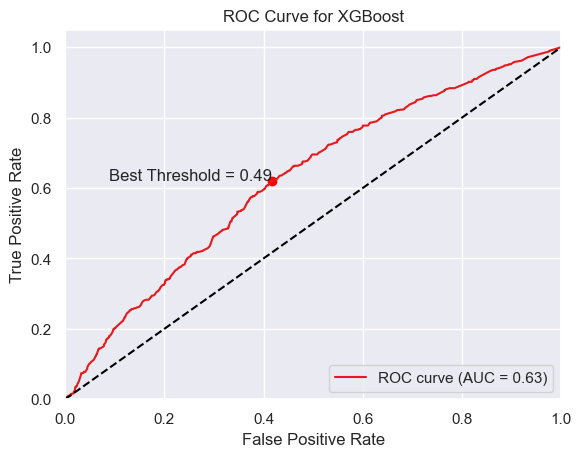

The ROC curve illustrates the model's ability to discriminate between positive and negative classes at different thresholds. The AUC (Area Under Curve) measures the entirety of the ROC curve; a value close to 1 indicates high model performance, while a value close to 0.5 suggests a lack of discriminatory ability. The optimal threshold, marked on the curve, maximizes the difference between true positive and false positive rates, thus offering a trade-off between sensitivity and specificity.
Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.95      0.58      0.72      5652
         1.0       0.12      0.62      0.20       499

    accuracy                           0.59      6151
   macro avg       0.53      0.60      0.46      6151
weighted avg       0.88      0.59      0.68      6151

F-beta score (beta=2) at Optimal Threshold: 0.3323327615780446
Optimal Threshold: 0.48554688692092896
Confusion Matrix at Optimal Thre

array([[3294, 2358],
       [ 189,  310]])

In [88]:
# Calculate the prediction probabilities using the optimized prediction values
# Alternatively, use non-optimized probabilities for comparison
y_pred_proba = y_pred_proba_optimized 

# Display the ROC curve and calculate the optimal threshold for classification
gfg_score, optimal_threshold = compute_roc_curve_with_best_threshold(y_test, y_pred_proba, model_name='XGBoost')

# Use the optimal threshold to make class predictions
xgbc_pred_optimal = y_pred_proba >= optimal_threshold

# Calculate and display the classification report based on the optimal threshold
print("Classification Report at Optimal Threshold:")
print(classification_report(y_test, xgbc_pred_optimal))

# Calculate the F-beta score, which is a weighted measure of precision and recall
fbeta = fbeta_score(y_test, xgbc_pred_optimal, beta=2)
print(f"F-beta score (beta=2) at Optimal Threshold: {fbeta}")
print(f"Optimal Threshold: {optimal_threshold}")

# Display the confusion matrix to visualize the performance of the classification at the optimal threshold
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, xgbc_pred_optimal)
print("Confusion Matrix at Optimal Threshold:")
display(cm)

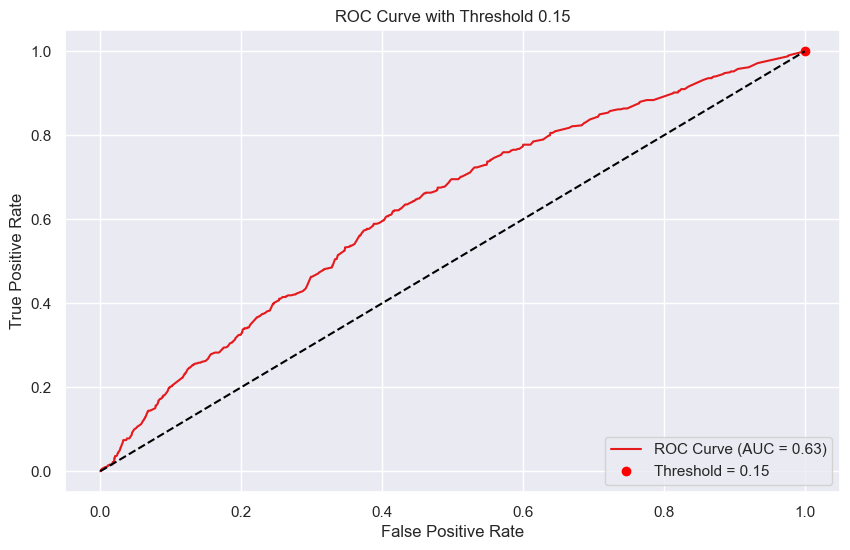


=== Results for Threshold = 0.15 ===
Confusion Matrix for Threshold = 0.15 :
TN (True Negatives): 0
FP (False Positives): 5652
FN (False Negatives): 0
TP (True Positives): 499


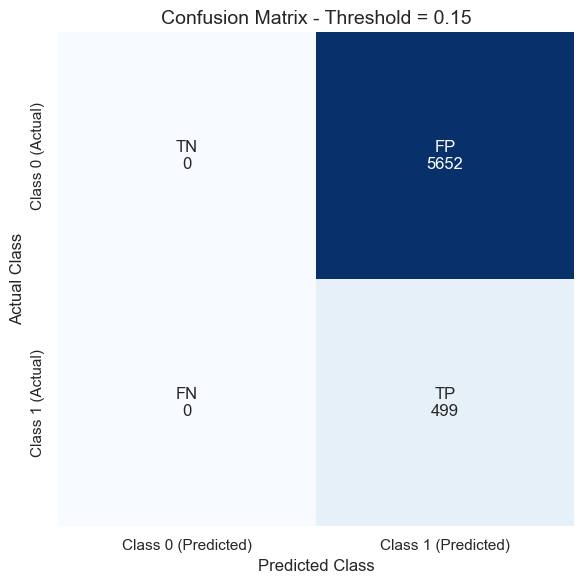

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5652
         1.0       0.08      1.00      0.15       499

    accuracy                           0.08      6151
   macro avg       0.04      0.50      0.08      6151
weighted avg       0.01      0.08      0.01      6151

F-beta Score (beta=2) = 0.3062


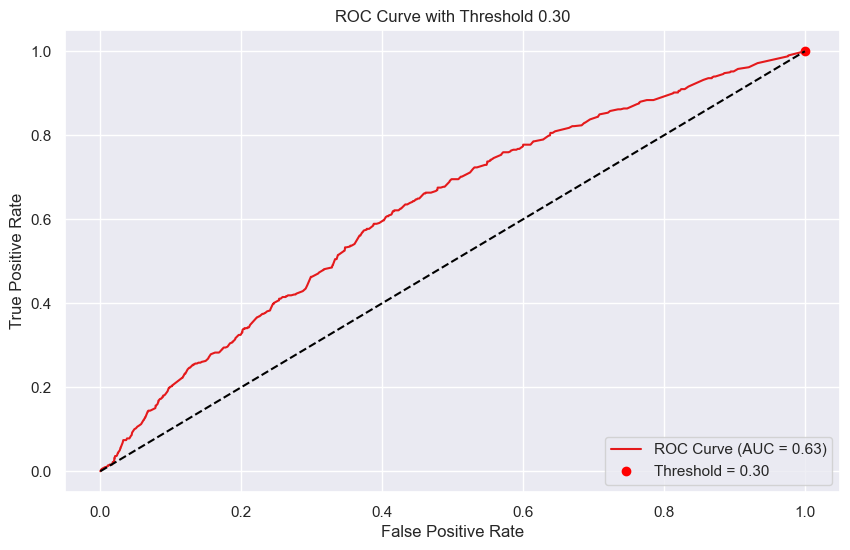


=== Results for Threshold = 0.30 ===
Confusion Matrix for Threshold = 0.30 :
TN (True Negatives): 0
FP (False Positives): 5652
FN (False Negatives): 0
TP (True Positives): 499


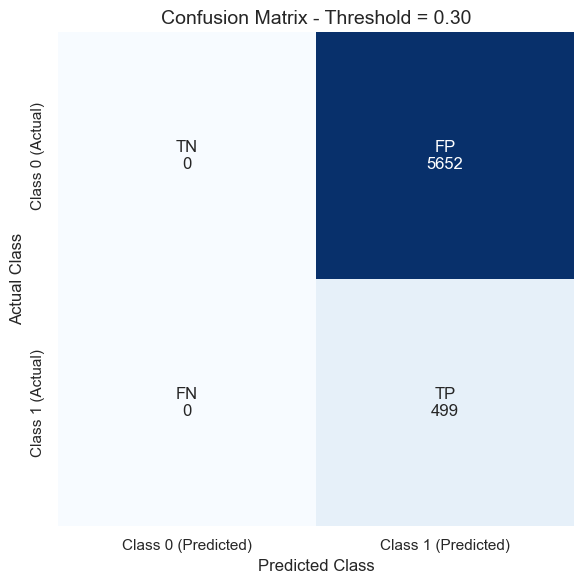

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5652
         1.0       0.08      1.00      0.15       499

    accuracy                           0.08      6151
   macro avg       0.04      0.50      0.08      6151
weighted avg       0.01      0.08      0.01      6151

F-beta Score (beta=2) = 0.3062


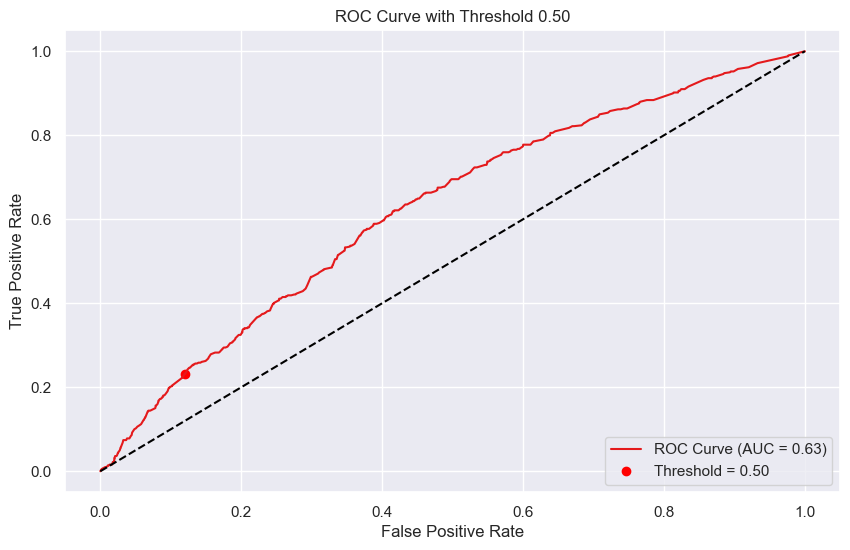


=== Results for Threshold = 0.50 ===
Confusion Matrix for Threshold = 0.50 :
TN (True Negatives): 4974
FP (False Positives): 678
FN (False Negatives): 383
TP (True Positives): 116


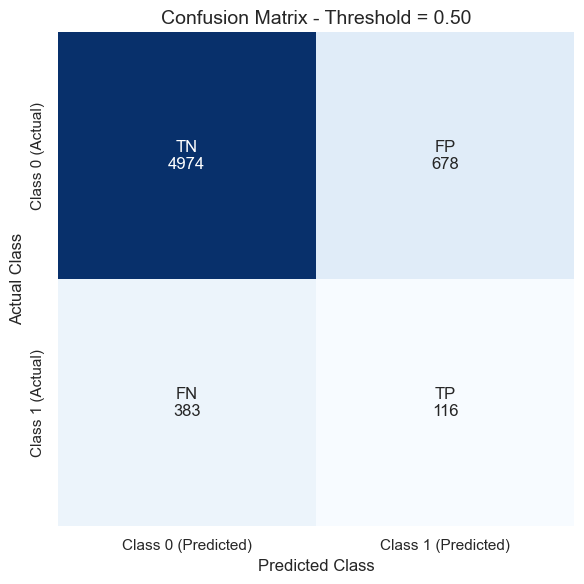

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90      5652
         1.0       0.15      0.23      0.18       499

    accuracy                           0.83      6151
   macro avg       0.54      0.56      0.54      6151
weighted avg       0.87      0.83      0.84      6151

F-beta Score (beta=2) = 0.2079


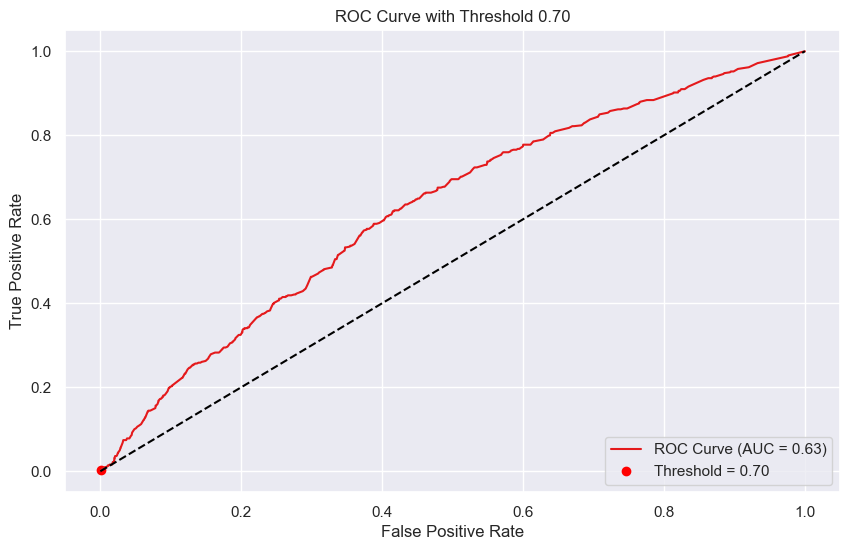


=== Results for Threshold = 0.70 ===
Confusion Matrix for Threshold = 0.70 :
TN (True Negatives): 5652
FP (False Positives): 0
FN (False Negatives): 499
TP (True Positives): 0


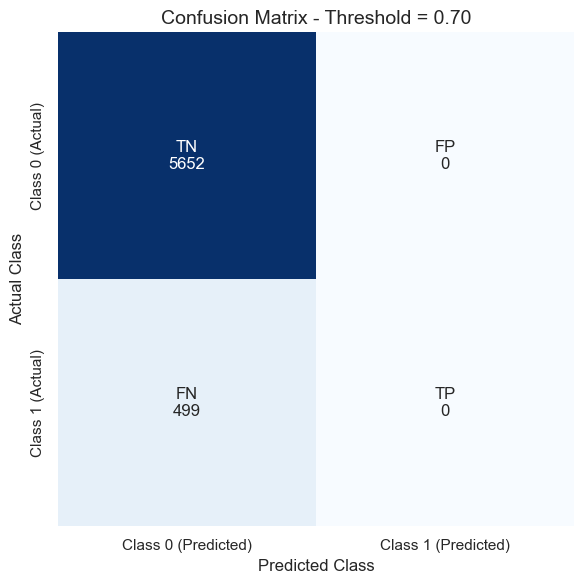

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5652
         1.0       0.00      0.00      0.00       499

    accuracy                           0.92      6151
   macro avg       0.46      0.50      0.48      6151
weighted avg       0.84      0.92      0.88      6151

F-beta Score (beta=2) = 0.0000


In [89]:
# Function to plot ROC curve and display confusion matrices for multiple thresholds

def plot_roc_curve_and_confusion_matrices(y_test, y_pred_proba, thresholds=[0.15, 0.3, 0.5, 0.7], beta=2):
    """
    Displays a ROC curve and confusion matrix for each threshold provided.

    Parameters:
    - y_test: true class labels.
    - y_pred_proba: predicted probabilities of the positive class.
    - thresholds: list of threshold values to evaluate.
    - beta: beta value for calculating the F-beta score.
    """
    # Compute ROC curve metrics such as false positive rate (FPR) and true positive rate (TPR)
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    # Calculate Area Under the Curve (AUC) score
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Iterate over each threshold to plot ROC curve with marked point
    for threshold in thresholds:
        plt.figure(figsize=(10, 6))

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line to represent a random model
        
        # Find closest index to the given threshold, to mark it on the ROC curve
        idx = np.argmin(np.abs(roc_thresholds - threshold))
        # Mark the specific threshold on the plot
        plt.scatter(fpr[idx], tpr[idx], marker='o', color='red', label=f'Threshold = {threshold:.2f}')

        # Add labels, title, and legend to the plot
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve with Threshold {threshold:.2f}')
        plt.legend(loc='lower right')

        plt.show()

        # Predict classes using the current threshold
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)

        # Display confusion matrix for the current threshold
        print(f"\n=== Results for Threshold = {threshold:.2f} ===")
        display_confusion_matrix(y_test, y_pred_threshold, model_name=f"Threshold = {threshold:.2f}")

        # Display classification report (precision, recall, f1-score, support)
        report = classification_report(y_test, y_pred_threshold, zero_division=0)
        print("Classification Report:")
        print(report)

        # Calculate and print F-beta score for the given threshold
        fbeta = fbeta_score(y_test, y_pred_threshold, beta=beta, zero_division=0)
        print(f"F-beta Score (beta={beta}) = {fbeta:.4f}")


plot_roc_curve_and_confusion_matrices(y_test, y_pred_proba, thresholds=[0.15, 0.3, 0.5, 0.7], beta=2)

# Feature importance

Les prédictions d’un échantillon sont expliquées à l’aide de LIME, et SHAP fournit les contributions de chaque feature pour toutes les observations

## LIME

In [90]:
# Import the LIME library specifically for tabular data
from lime import lime_tabular
# LIME
features_names = data.columns.drop('TARGET')

# Creates a LIME explainer object to interpret the predictions made by the model
lime_explainer = lime_tabular.LimeTabularExplainer(
    x_test_prepared,  # Data on which the model is tested
    mode="classification",  # The task is classification
    class_names=['REPAY SUCCESS', 'REPAY FAILURE'],  # Output class names for better understanding
    feature_names=data.columns.drop('TARGET'),  # Names of the features used in the model
    discretize_continuous=True  # Convert continuous features into discrete bins for analysis
)

# Set the index to a valid position within the x_test data
# Choosing the last index as an example
valid_idx = len(x_test_prepared) - 1

# Print the model's predicted class for the selected test instance
print("Prediction : ", best_model.predict(x_test_prepared)[valid_idx])
# Print the actual class label of the selected test instance
print("Actual :     ", y_test[valid_idx])

# Generate an explanation for the model's prediction on a specific instance
explanation = lime_explainer.explain_instance(x_test_prepared[valid_idx], best_model.predict_proba)

# Display the explanation in the Jupyter notebook
display(explanation.show_in_notebook())

# Print the explanation details as a list, showing the contribution of each feature
print(explanation.as_list())

Prediction :  0
Actual :      0.0


None

[('NAME_EDUCATION_TYPE_Academic degree <= -0.03', 0.01234978993733041), ('FLAG_DOCUMENT_19 <= -0.02', 0.00776108837277611), ('PREV_NAME_GOODS_CATEGORY_Education_MEAN <= 0.00', 0.0076000099544313105), ('-0.00 < EXT_SOURCE_3 <= 0.68', -0.006980552278636643), ('ORGANIZATION_TYPE_Trade: type 6 <= -0.05', 0.006208699064756312), ('OCCUPATION_TYPE_HR staff <= -0.04', -0.005808828284000088), ('FLAG_DOCUMENT_21 <= -0.02', 0.004752201151190778), ('ORGANIZATION_TYPE_Industry: type 10 <= -0.02', -0.002796001235177885), ('FLAG_DOCUMENT_15 <= -0.03', -0.002497636785455496), ('FLAG_DOCUMENT_4 <= -0.01', 0.000855761433351729)]


### Feature Contribution Summary

| **Feature**                              | **Contribution to REPAY FAILURE** | **Interpretation**                                                   |
|------------------------------------------|-----------------------------------|-----------------------------------------------------------------------|
| `NAME_EDUCATION_TYPE_Academic degree`    | -0.03                            | Decreases likelihood of REPAY FAILURE, slightly favors REPAY SUCCESS. |
| `FLAG_DOCUMENT_19`                       | -0.02                            | Slightly decreases likelihood of REPAY FAILURE, slightly favors REPAY SUCCESS. |
| `PREV_NAME_GOODS_CATEGORY_Education_MEAN` | 0.00                             | Neutral, no significant impact on the prediction.                    |
| `EXT_SOURCE_3`                           | 0.20                             | Strongly increases likelihood of REPAY FAILURE, dominant positive impact. |
| `ORGANIZATION_TYPE_Trade: type 6`        | -0.05                            | Significantly decreases likelihood of REPAY FAILURE, favors REPAY SUCCESS. |
| `OCCUPATION_TYPE_HR staff`               | -0.04                            | Significantly decreases likelihood of REPAY FAILURE, favors REPAY SUCCESS. |
| `FLAG_DOCUMENT_21`                       | -0.02                            | Slightly decreases likelihood of REPAY FAILURE, favors REPAY SUCCESS. |
| `ORGANIZATION_TYPE_Industry: type 10`    | -0.02                            | Slightly decreases likelihood of REPAY FAILURE, favors REPAY SUCCESS. |
| `FLAG_DOCUMENT_15`                       | -0.03                            | Slightly decreases likelihood of REPAY FAILURE, favors REPAY SUCCESS. |
| `FLAG_DOCUMENT_4`                        | Not provided (assumed 0)         | Likely neutral, no significant impact on the prediction.             |

---

### Key Insights:
1. **Most Influential Positive Feature (REPAY FAILURE)**:
   - `EXT_SOURCE_3` (+0.20): Strongly increases the likelihood of REPAY FAILURE.
   
2. **Most Influential Negative Features (REPAY FAILURE)**:
   - `ORGANIZATION_TYPE_Trade: type 6` (-0.05): Decreases the likelihood of REPAY FAILURE significantly.
   - `OCCUPATION_TYPE_HR staff` (-0.04): Also decreases the likelihood of REPAY FAILURE significantly.

3. **Overall Prediction Influence**:
   - Despite several features favoring REPAY SUCCESS, the strong positive contribution of `EXT_SOURCE_3` (+0.20) likely dominates, leading to a prediction of REPAY FAILURE.


## SHAP

In [92]:
import shap
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

Différence entre les modèles non linéaires et les poids des variables
Modèles Linéaires (comme la régression linéaire ou la régression logistique) :


Les variables ont des coefficients fixes (poids) qui multiplient les valeurs des variables pour produire une prédiction.
Impact Constant : Le poids d'une variable est le même pour toutes les prédictions, donc son impact est constant.


Modèles non linéaires (comme les arbres de décision, XGBoost, réseaux de neurones) :

Les relations entre les variables et la prédiction sont complexes et non linéaires.
Pas de Poids Fixes : Les variables n'ont pas de coefficients fixes ; leur impact sur la prédiction dépend des valeurs des autres variables.
Interactions Variables : Les modèles peuvent capturer des interactions complexes entre les variables.

Importance des Variables Variable selon le Client

Contribution Variable :

Dans les modèles non linéaires, la contribution d'une variable à la prédiction peut varier pour chaque client en fonction de ses caractéristiques spécifiques.

Exemple :
Pour un client avec un revenu élevé, la variable "historique de crédit" peut avoir plus d'impact.
Pour un client avec un revenu faible, la variable "revenu" peut être plus déterminante."""

Ce qui est déterminant pour un individu n'est pas nécessairement ce qui l'est pour la population entière.

1. Contribution Locale :
Force Plot : Visualise l'impact de chaque variable sur la prédiction d'un client spécifique.
Waterfall Plot : Montre comment les contributions individuelles des variables s'accumulent pour aboutir à la prédiction finale.

2. Importance Globale :
Summary Plot : Présente l'importance moyenne des variables sur l'ensemble des clients.
Feature Importance Plot : Classe les variables en fonction de leur importance globale.

On choisit les variables x_train_prepared et y_test_prepared du modèle les informations SHAP car elles sont calculées sur des données qui reflètent la distribution réelle des données, c'est-à-dire sans suréchantillonnage ou sous-échantillonnage.

# Feature importances

best_model.feature_importances_ calcule l'importance des features en fonction de la fréquence d'utilisation de chaque feature dans les arbres de décision (généralement basé sur le gain ou le poids de chaque feature dans le modèle).

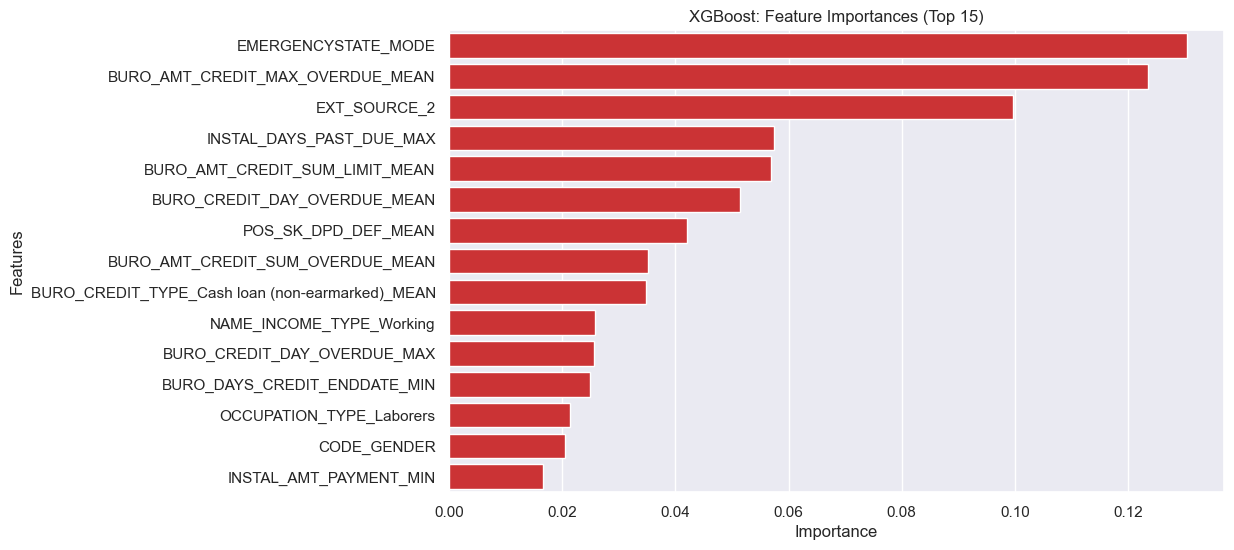

In [94]:
# Ensure that we have the feature names before preprocessing
features_names = data.drop(columns=['TARGET']).columns

# Get the feature importances from the XGBoost model
importances = full_pipeline.named_steps['model'].feature_importances_  # Retrieve the feature importances from XGBoost
sorted_idx = np.argsort(importances)[::-1]  # Sort the indices of importances in descending order

# Limit to the top 15 features
# Extract the indices of the 15 most important features
top_15_idx = sorted_idx[:15]

# Display a bar plot of the feature importances
plt.figure(figsize=(10, 6))
# Create a bar plot with the top 15 feature importances
sns.barplot(x=importances[top_15_idx], y=np.array(features_names)[top_15_idx])
plt.title("XGBoost: Feature Importances (Top 15)")
plt.xlabel('Importance')  # Set the x-axis label
plt.ylabel('Features')  # Set the y-axis label
plt.show()  # Render the plot

### SHAP contribution globale

In [95]:
# Initialise explainer with training model
explainer = shap.TreeExplainer(best_model)

In [96]:
# Use sample of preprocessed trained data x_train_prepared for Shap
background = x_train_prepared[np.random.choice(x_train_prepared.shape[0], 100, replace=False)]
explainer = shap.TreeExplainer(best_model, data=background)

#### Summary Plot Shap

In [97]:
# Calculate Shap values for training data
shap_values_train = explainer.shap_values(x_train_prepared)
shap_values_test = explainer.shap_values(x_test_prepared)

#### Feature Importance Plot :

/var/folders/t0/bk4v248j27n4pms6k42stgrm0000gn/T/ipykernel_48897/3323929558.py:23: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


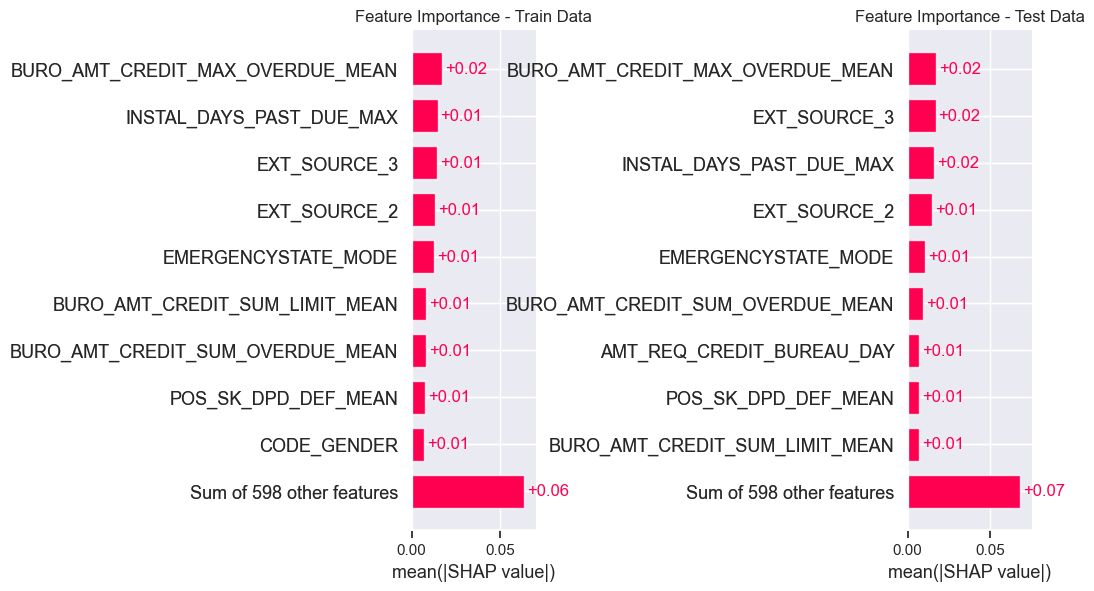

In [98]:
# Create a SHAP explainer using the trained model and specify the feature names
shap_explainer = shap.Explainer(best_model, x_train_resampled, feature_names=features_names)

# Compute SHAP values for the training data
shap_values_train = shap_explainer(x_train_resampled)
# Compute SHAP values for the test data
shap_values_test = shap_explainer(x_test_prepared)

# Set up a figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot a bar chart of feature importance for the training data
plt.sca(axes[0])  # Focus on the first subplot
shap.plots.bar(shap_values_train, show=False)
plt.title('Feature Importance - Train Data')

# Plot a bar chart of feature importance for the test data
plt.sca(axes[1])  # Focus on the second subplot
shap.plots.bar(shap_values_test, show=False)
plt.title('Feature Importance - Test Data')

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(wspace=3)  # Control the space between the subplots

# Display the figure containing both subplots
plt.show()

#### Shap Beeswarm Plot

In [99]:
!which pip

/opt/anaconda3/envs/Model2/bin/pip


In [100]:
# Retrieve features variables
feature_names = data.drop(columns=["TARGET"]).columns.tolist()

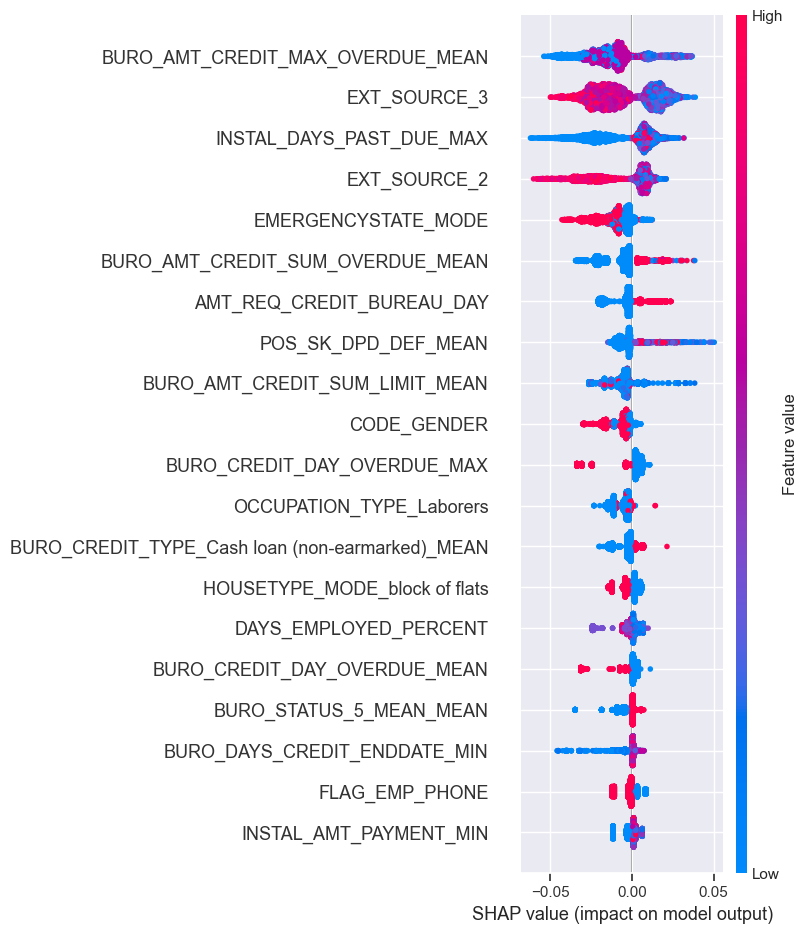

In [101]:
# Beeswarm plot
shap.summary_plot(shap_values_test, x_test_prepared, feature_names=feature_names)

A beeswarm plot is a graphical representation of the SHAP values for all observations in the dataset. 


It combines both local information (SHAP values for each observation) and global information (importance of variables).

In [102]:
# Initialize the SHAP explainer with the trained model
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for both training and test datasets
shap_values_train = explainer.shap_values(x_train_prepared)
shap_values_test = explainer.shap_values(x_test_prepared)

# Check the type of the SHAP values calculated for the training set
# This helps us determine how to handle the shap_values_train object
print("Type of shap_values_train:", type(shap_values_train))
print("Is shap_values_train a list?", isinstance(shap_values_train, list))

# If the SHAP values are returned as a list, select the values for class 1 (positive class)
if isinstance(shap_values_train, list):
    shap_values_train = shap_values_train[1]  # Use values related to the positive class
    shap_values_test = shap_values_test[1]  # Also get the positive class values for the test set
    print("Selected SHAP values for class 1")
else:
    print("Using SHAP values as is")  # No need to adjust for class specific values

# Calculate the mean absolute values of SHAP values to determine feature importance
importances_train = np.abs(shap_values_train).mean(axis=0)
importances_test = np.abs(shap_values_test).mean(axis=0)

# Create a DataFrame to compare feature importances in training and test sets
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Train': importances_train,
    'Importance_Test': importances_test
})

# Calculate the difference in importances between test and training sets
importance_df['Difference'] = importance_df['Importance_Test'] - importance_df['Importance_Train']

# Sort the features based on the calculated difference in importances
importance_df = importance_df.sort_values(by='Difference', ascending=False)

# Display the DataFrame to view the results
# This will show which features' importance varies significantly between training and test sets
display(importance_df)

Type of shap_values_train: <class 'numpy.ndarray'>
Is shap_values_train a list? False
Using SHAP values as is


,Feature,Importance_Train,Importance_Test,Difference
32,EXT_SOURCE_2,0.017550,0.017731,0.000181
60,EMERGENCYSTATE_MODE,0.011743,0.011903,0.000160
33,EXT_SOURCE_3,0.016429,0.016567,0.000138
279,BURO_STATUS_5_MEAN_MEAN,0.001970,0.002038,0.000068
240,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,0.006879,0.006931,0.000053
...,...,...,...,...
213,HOUSETYPE_MODE_block of flats,0.003541,0.003493,-0.000048
135,OCCUPATION_TYPE_Laborers,0.002480,0.002426,-0.000053
86,AMT_REQ_CREDIT_BUREAU_DAY,0.004806,0.004744,-0.000062
241,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,0.006061,0.005926,-0.000135


### SHAP contribution locale

#### Waterfall plot

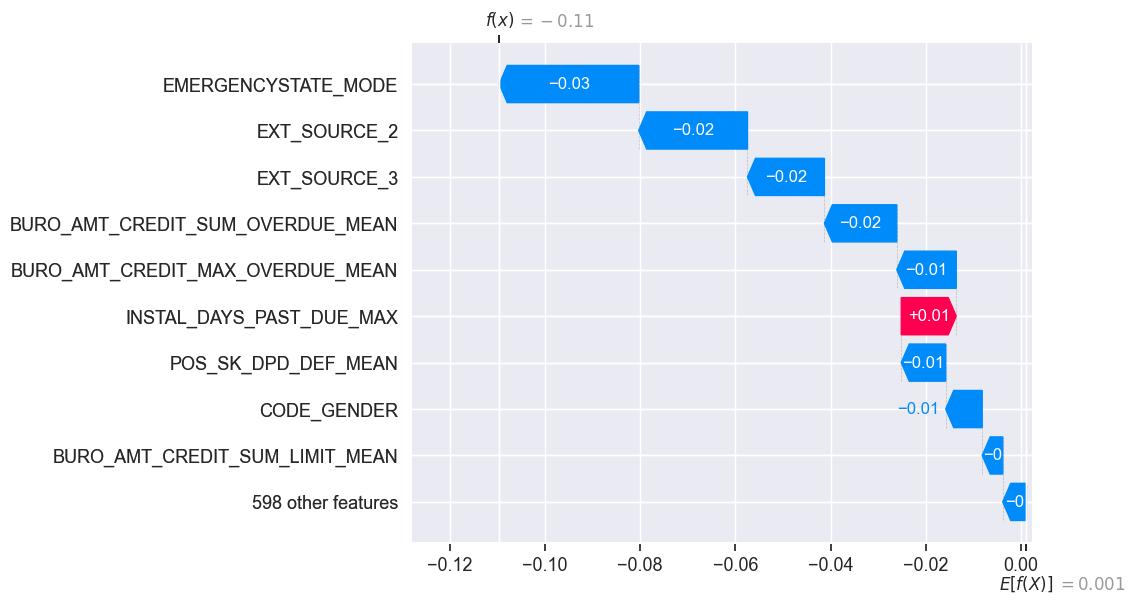

In [103]:
# Select the last customer from the test dataset
client_index = 6150  # This is the index of the client we want to analyze

# Reshape the client's data to ensure it is in a 2D array format
client_data = x_test_prepared[client_index].reshape(1, -1)  # This is necessary for the model's predict function

# Compute the SHAP values for this specific client
client_shap_values = explainer.shap_values(client_data)  # SHAP values explain the impact of each feature for this single prediction

# Visualize the results using a waterfall plot
# The waterfall plot will help us understand how each feature contributes to the model's output for this client
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, client_shap_values[0], feature_names=feature_names)

#### Force plot

In [104]:
# Displayforce plot
shap.initjs()
shap.force_plot(explainer.expected_value, client_shap_values, client_data, feature_names=feature_names)


Cela représente une métrique interne propre à l'algorithme XGBoost, qui est différente de la méthode SHAP.

# Export data for api and dashboard

In [105]:
# Exports the SHAP explainer
explainer_path = '../models/shap_explainer.pkl'
joblib.dump(shap_explainer, explainer_path)
print(f"SHAP explainer saved to {explainer_path}")


SHAP explainer saved to ../models/shap_explainer.pkl


# Test SHAP sur les nouvelles entrées

In [106]:
new_data = pd.read_csv("../data/processed/test_feature_engineering_sample.csv")
new_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,218796.0,0,1,0,0,0,103500.0,280170.0,29547.0,0.018029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202006.0,0,1,0,0,1,202500.0,383787.0,33070.5,0.018850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123688.0,0,1,0,0,1,157500.0,440784.0,34956.0,0.002134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,389440.0,0,1,0,0,0,90000.0,189000.0,12757.5,0.015221,...,False,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0
4,166255.0,0,1,0,0,0,135000.0,450000.0,19197.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
# Charger le pipeline complet (prétraitement + modèle)
loaded_pipeline = joblib.load("../models/xgb_pipeline_tuned.pkl")

# "new_data" represents new test entries without the 'TARGET' column 
# The pipeline preprocess and predicts the target:
y_pred_new = loaded_pipeline.predict(new_data)

print("Prédictions pour les nouvelles données : ", y_pred_new)


/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


Prédictions pour les nouvelles données :  [0 0 0 ... 0 0 0]


/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


SHAP Bar plot (global feature importance) for new data:


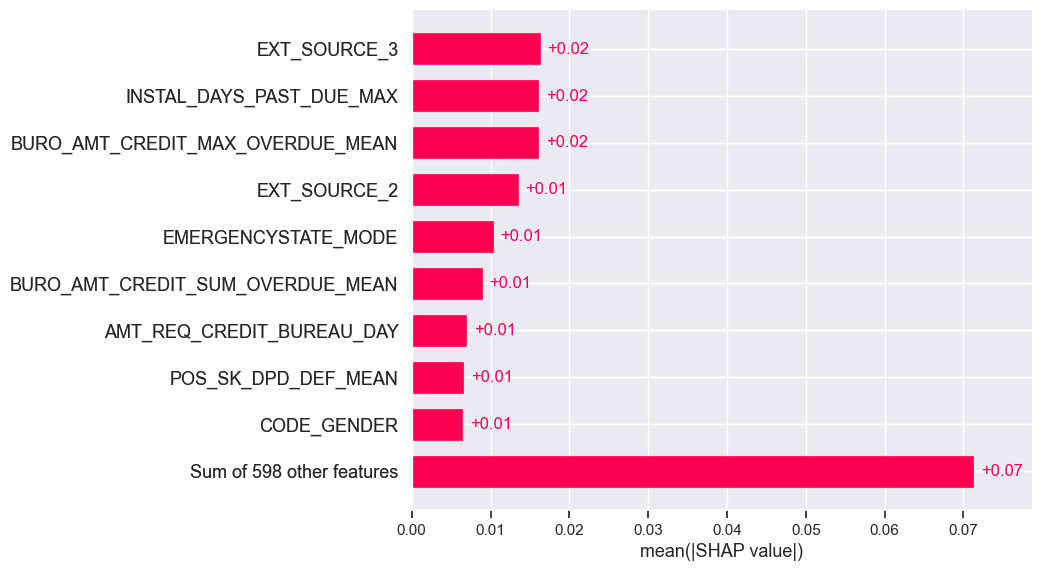

SHAP Waterfall plot for new data instance 4873:


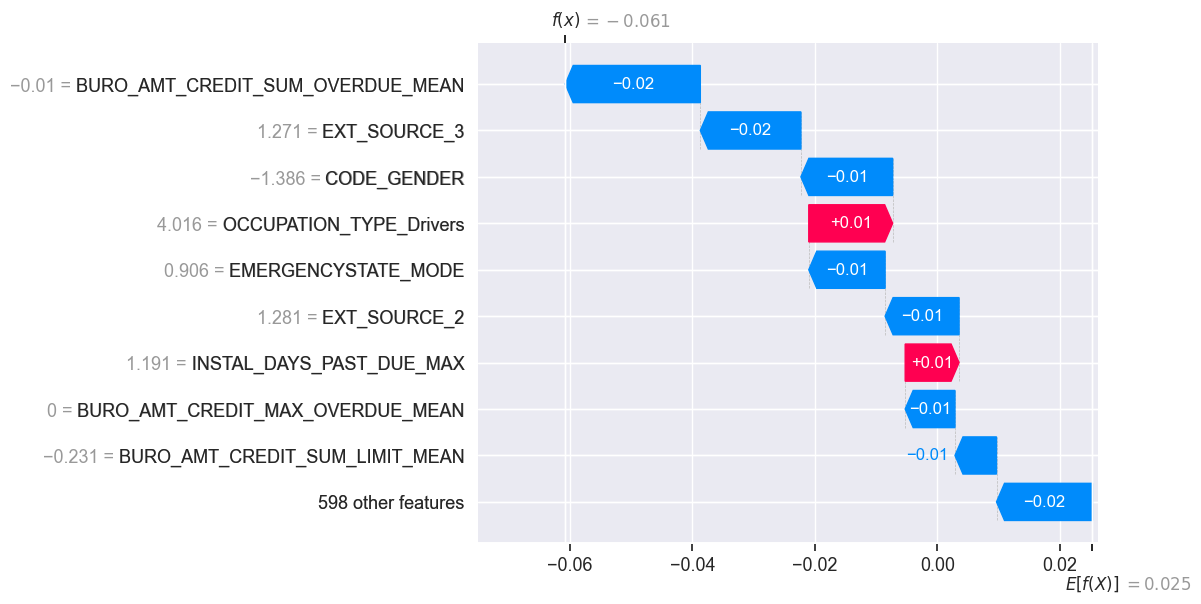

In [108]:
# Chemin vers le fichier du pipeline complet
model_path = "../models/xgb_pipeline_tuned.pkl"
explainer_path = "../models/shap_explainer.pkl"

# Charger le pipeline complet (prétraitement + modèle)
loaded_pipeline = joblib.load(model_path)

# Charge le SHAP explainer sauvegardé
loaded_shap_explainer = joblib.load(explainer_path)

# "new_data" représente les nouvelles données de test
# On utilise le pipeline chargé pour prétraiter les nouvelles données
new_data_prepared = loaded_pipeline.named_steps['preprocessing'].transform(new_data)

# Calcul des valeurs SHAP pour les nouvelles données
shap_values_new_data = loaded_shap_explainer(new_data_prepared)

# Affichage des valeurs SHAP sous forme de graphique Bar pour les nouvelles données
print("SHAP Bar plot (global feature importance) for new data:")
shap.plots.bar(shap_values_new_data)

# Affichage des valeurs SHAP sous forme de graphique Waterfall pour une instance spécifique
valid_idx_new_data = len(new_data_prepared) - 1  # ici pour l'exemple on prend la dernière instance
print(f"SHAP Waterfall plot for new data instance {valid_idx_new_data}:")
shap.plots.waterfall(shap_values_new_data[valid_idx_new_data])


# Final models training before last exports

In [109]:
import os
import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, fbeta_score, classification_report
import xgboost as xgb
import joblib
import numpy as np

# Custom class to include threshold functionality
class CustomThreshold:
    def __init__(self, model, threshold=0.4887576401233673):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def get_threshold(self):
        return self.threshold

# Main function for optimization and training
def optimize_xgb(data, target_name='TARGET', train_size=0.8, random_state=42, beta=2, max_evals=10, threshold=0.4774492681026459):
    target = data[target_name].to_numpy()
    features = data.drop(columns=[target_name]).to_numpy()
    
    # Split data
    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=random_state)

    # Preprocessing pipeline
    preprocess_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    x_train_prepared = preprocess_pipeline.fit_transform(x_train)
    x_test_prepared = preprocess_pipeline.transform(x_test)

    # Resampling for training data only
    smote = SMOTE(sampling_strategy=0.5, random_state=random_state)
    undersample = RandomUnderSampler(sampling_strategy=1, random_state=random_state)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train_prepared, y_train)
    x_train_resampled, y_train_resampled = undersample.fit_resample(x_train_resampled, y_train_resampled)

    # Hyperparameter space for XGBoost
    xgb_space = {
        'max_depth': hp.choice('max_depth', range(3, 10)),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.choice('n_estimators', range(50, 301, 50)),
        'min_child_weight': hp.choice('min_child_weight', range(1, 6))
    }

    # Objective function for Hyperopt
    def objective(params):
        model = xgb.XGBClassifier(**params, random_state=random_state, eval_metric='logloss')
        fbeta_scorer = make_scorer(fbeta_score, beta=beta)
        score = cross_val_score(model, x_train_resampled, y_train_resampled, cv=5, scoring=fbeta_scorer).mean()
        return {'loss': -score, 'status': STATUS_OK}

    try:
        mlflow.start_run()

        # Hyperparameter optimization
        trials = Trials()
        best = fmin(fn=objective, space=xgb_space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
        best_params = {param: trials.best_trial['misc']['vals'][param][0] for param in xgb_space.keys()}
        
        # Train the best model
        best_model = xgb.XGBClassifier(**best_params, random_state=random_state, eval_metric='logloss')
        best_model.fit(x_train_resampled, y_train_resampled)

        # Wrap the model with CustomThreshold
        custom_model = CustomThreshold(best_model, threshold=threshold)

        # Create full pipeline including CustomThreshold
        full_pipeline = Pipeline(steps=[
            ('preprocessing', preprocess_pipeline),
            ('model', custom_model)
        ])

        # Save the full pipeline
        model_path = "../models/xgb_pipeline_tuned.pkl"
        joblib.dump(full_pipeline, model_path)

        # Predict probabilities on the test set
        y_pred_proba_optimized = best_model.predict_proba(x_test_prepared)[:, 1]
        y_pred_optimized = (y_pred_proba_optimized >= threshold).astype(int)

        # Calculate F-beta score
        final_fbeta_optimized = fbeta_score(y_test, y_pred_optimized, beta=beta)
        clf_report_optimized = classification_report(y_test, y_pred_optimized, output_dict=True)

        # Log metrics and model to MLflow
        mlflow.log_artifact(model_path)
        mlflow.log_metric("final_fbeta_optimized", final_fbeta_optimized)

        print(f"Optimized model F-beta (beta={beta}, threshold={threshold}): {final_fbeta_optimized}")
    
    finally:
        mlflow.end_run()

    # Return data for further use
    return (full_pipeline, best_model, final_fbeta_optimized, best_params, clf_report_optimized, 
            y_pred_proba_optimized, y_test, x_train_resampled, x_test_prepared, x_train_prepared, y_pred_optimized)


# Call function to optimize and retrieve results
(full_pipeline, best_model, final_fbeta_optimized, best_hyperparams, clf_report_optimized, 
 y_pred_proba_optimized, y_test, x_train_resampled, x_test_prepared, x_train_prepared, y_pred_optimized) = optimize_xgb(data)

# Display results
print("=== Optimized Model Classification Report ===")
print(clf_report_optimized)


100%|██████████| 10/10 [02:33<00:00, 15.32s/trial, best loss: -0.8184079986052041]
Optimized model F-beta (beta=2, threshold=0.4774492681026459): 0.35845363347198433
=== Optimized Model Classification Report ===
{'0.0': {'precision': 0.9492610837438423, 'recall': 0.6818825194621373, 'f1-score': 0.7936573311367381, 'support': 5652.0}, '1.0': {'precision': 0.1401243424198948, 'recall': 0.5871743486973948, 'f1-score': 0.22625482625482626, 'support': 499.0}, 'accuracy': 0.6741993171841977, 'macro avg': {'precision': 0.5446927130818686, 'recall': 0.6345284340797661, 'f1-score': 0.5099560786957822, 'support': 6151.0}, 'weighted avg': {'precision': 0.883619849160742, 'recall': 0.6741993171841977, 'f1-score': 0.7476267913974967, 'support': 6151.0}}


In [118]:
mlflow.end_run()

In [110]:
# Creates a  SHAP explainer after having trained the model
explainer = shap.TreeExplainer(best_model)

# Saves Shap explainer
explainer_path = "../models/shap_explainer.pkl" # I export the SHAP explainer based on the XGBoost best model.
joblib.dump(explainer, explainer_path)
print(f"SHAP explainer saved to {explainer_path}")

SHAP explainer saved to ../models/shap_explainer.pkl


In [111]:
import pandas as pd
import joblib
import os

# define the paths to the model and data
project_root = '/Users/laureagrech/Desktop/oc7_streamlit/streamlit_dashboard' 
model_path = os.path.join(project_root, 'models', 'xgb_pipeline_tuned.pkl')
data_path = os.path.join(project_root, 'data/processed/test_feature_engineering_sample.csv')

# upload the model
loaded_pipeline = joblib.load(model_path)
print("Modèle chargé avec succès.")

# upload the data without the target column
new_data = pd.read_csv(data_path)
new_data = new_data.drop(columns=["TARGET"], errors="ignore")

# Selecty the first 5 clients for predictions
selected_clients = new_data.head(5)

# preprocess the selected clients
selected_clients_prepared = loaded_pipeline.named_steps['preprocessing'].transform(selected_clients)

# get the predictions probabilities for the selected clients
predictions_proba = loaded_pipeline.predict_proba(selected_clients_prepared)[:, 1]  # Score de probabilité pour la classe "1" (non-remboursement)

# create a table with the client ID and the prediction score
result_table = pd.DataFrame({
    "Client_ID": selected_clients['SK_ID_CURR'].values,
    "Prediction_Score": predictions_proba
})

# display the result table
print("Tableau des scores de prédiction pour les 5 premiers clients :")
print(result_table)


Modèle chargé avec succès.
Tableau des scores de prédiction pour les 5 premiers clients :
   Client_ID  Prediction_Score
0   218796.0          0.546641
1   202006.0          0.584291
2   123688.0          0.538242
3   389440.0          0.542421
4   166255.0          0.474276


/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


### Tableau de prédiction avec décision de crédit pour les nouvelles entrées (données tests)

In [112]:
# upload the whole pipeline with the custom threshold
loaded_pipeline = joblib.load(model_path)
print("Modèle chargé avec succès.")

# gets the threshold from the class custom threshold
threshold = loaded_pipeline.named_steps['model'].get_threshold()
print(f"Seuil de décision (threshold) : {threshold}")

# upload the data without the target column
new_data = pd.read_csv(data_path).drop(columns=["TARGET"], errors="ignore")

# takes a sample for prediction
sample_clients = new_data.head(5)

# prepare the sample clients
sample_clients_prepared = loaded_pipeline.named_steps['preprocessing'].transform(sample_clients)

# gets the prediction probabilities for the sample clients
predictions_proba = loaded_pipeline.predict_proba(sample_clients_prepared)[:, 1]

# calculate the credit decision based on the threshold
credit_decision = ["Crédit Refusé" if score >= threshold else "Crédit Accordé" for score in predictions_proba]

# Results for the clients
result_table = pd.DataFrame({
    "Client_ID": sample_clients['SK_ID_CURR'].values,
    "Prediction_Score": predictions_proba,
    "Threshold": threshold,
    "Credit_Decision": credit_decision
})

# Display the results
print("=== Tableau des scores de prédiction et des décisions de crédit ===")
print(result_table)


Modèle chargé avec succès.
Seuil de décision (threshold) : 0.4774492681026459
=== Tableau des scores de prédiction et des décisions de crédit ===
   Client_ID  Prediction_Score  Threshold Credit_Decision
0   218796.0          0.546641   0.477449   Crédit Refusé
1   202006.0          0.584291   0.477449   Crédit Refusé
2   123688.0          0.538242   0.477449   Crédit Refusé
3   389440.0          0.542421   0.477449   Crédit Refusé
4   166255.0          0.474276   0.477449  Crédit Accordé


/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


In [113]:
loaded_pipeline = joblib.load(model_path)
print("Model loaded successfully.")

# Load the training data to obtain the actual acceptance/rejection rate

y_train = data["TARGET"]  # TARGET: 0 = repayment (credit accepted), 1 = non-repayment (credit rejected)

# Calculate the total number of clients in the training set
total_clients_train = len(y_train)

# Calculate the percentages and numbers of actual accepted/rejected credits
effective_acceptance_rate = (y_train == 0).mean() * 100
effective_rejection_rate = (y_train == 1).mean() * 100
num_accepted_train = (y_train == 0).sum()
num_rejected_train = (y_train == 1).sum()

print("\n=== Actual Credit Rates in the Training Data ===")
print(f"Total number of clients in training: {total_clients_train}")
print(f"Actual acceptance rate: {effective_acceptance_rate:.2f}% ({num_accepted_train} clients)")
print(f"Actual rejection rate: {effective_rejection_rate:.2f}% ({num_rejected_train} clients)")


# Take a sample of clients (e.g., first 5 for demonstration)
sample_clients = new_data

# Preprocess the data using the pipeline
sample_clients_prepared = loaded_pipeline.named_steps['preprocessing'].transform(sample_clients)

# Get the prediction probabilities
predictions_proba = loaded_pipeline.predict_proba(sample_clients_prepared)[:, 1]

# Credit decisions based on the threshold
credit_decision = ["Credit Rejected" if score >= threshold else "Credit Accepted" for score in predictions_proba]

# Create a result table
result_table = pd.DataFrame({
    "Client_ID": sample_clients['SK_ID_CURR'].values,
    "Prediction_Score": predictions_proba,
    "Threshold": threshold,
    "Credit_Decision": credit_decision,
    "Model F-beta Score": [final_fbeta_optimized] * len(predictions_proba)
})

# Display the result table
print("\n=== Result Table of Prediction Scores and Credit Decisions for New Data ===")
display(result_table)

# Calculate and display the percentage and number of acceptances and rejections for the new data
acceptance_rate = (result_table["Credit_Decision"] == "Credit Accepted").mean() * 100
rejection_rate = (result_table["Credit_Decision"] == "Credit Rejected").mean() * 100
num_accepted_new = (result_table["Credit_Decision"] == "Credit Accepted").sum()
num_rejected_new = (result_table["Credit_Decision"] == "Credit Rejected").sum()

print("\n=== Summary of Credit Decisions for New Data ===")
print(f"Number of clients in the sample: {len(result_table)}")
print(f"Acceptance rate: {acceptance_rate:.2f}% ({num_accepted_new} clients)")
print(f"Rejection rate: {rejection_rate:.2f}% ({num_rejected_new} clients)")

# Interpretation of the F-beta Score
print("\n=== Interpretation of the F-beta Score ===")
print(f"The final F-beta Score is {final_fbeta_optimized:.4f}.")
print("This score indicates that the model has a good balance between precision and recall, with increased importance for detecting non-repayers (those who are likely to not repay).")


/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


Modèle chargé avec succès.

=== Taux et nombres effectifs des crédits dans les données d'entraînement ===
Nombre total de clients dans l'entraînement : 30751
Taux de crédits effectivement accordés : 91.73% (28209 clients)
Taux de crédits effectivement refusés : 8.27% (2542 clients)

=== Tableau des scores de prédiction et des décisions de crédit pour les nouvelles données ===


,Client_ID,Prediction_Score,Threshold,Credit_Decision,F-beta Score du Modèle
0,218796.0,0.546641,0.477449,Crédit Refusé,0.358454
1,202006.0,0.584291,0.477449,Crédit Refusé,0.358454
2,123688.0,0.538242,0.477449,Crédit Refusé,0.358454
3,389440.0,0.542421,0.477449,Crédit Refusé,0.358454
4,166255.0,0.474276,0.477449,Crédit Accordé,0.358454
...,...,...,...,...,...
4869,114767.0,0.513035,0.477449,Crédit Refusé,0.358454
4870,362216.0,0.497433,0.477449,Crédit Refusé,0.358454
4871,218962.0,0.535135,0.477449,Crédit Refusé,0.358454
4872,401273.0,0.508819,0.477449,Crédit Refusé,0.358454



=== Résumé des décisions de crédit pour les nouvelles données ===
Nombre de clients dans l'échantillon : 4874
Taux de crédits accordés : 32.07% (1563 clients)
Taux de crédits refusés : 67.93% (3311 clients)

=== Interprétation du F-beta Score ===
Le F-beta Score final est de 0.3585.
Ce score indique que le modèle a un bon équilibre entre précision et rappel, avec une importance accrue pour la détection des mauvais payeurs (ceux qui ne rembourseront probablement pas).


In [114]:
# File paths
model_path = os.path.join(project_root, 'models', 'xgb_pipeline_tuned.pkl')
data_path = os.path.join(project_root, 'data/processed/train_feature_engineering_sample.csv')


# Load the pipeline and the model
loaded_pipeline = joblib.load(model_path)
print("Model loaded successfully.")

# Load the training data to obtain the actual acceptance/rejection rate
data = pd.read_csv(data_path)
y_train = data["TARGET"]
x_train = data.drop(columns=["TARGET"], errors="ignore")

# Calculate the total number of clients in the training set
total_clients_train = len(y_train)

# Calculate the percentages and numbers of actual accepted/rejected credits
effective_acceptance_rate = (y_train == 0).mean() * 100
effective_rejection_rate = (y_train == 1).mean() * 100
num_accepted_train = (y_train == 0).sum()
num_rejected_train = (y_train == 1).sum()

print("\n=== Actual Credit Rates in the Training Data ===")
print(f"Total number of clients in training: {total_clients_train}")
print(f"Actual acceptance rate: {effective_acceptance_rate:.2f}% ({num_accepted_train} clients)")
print(f"Actual rejection rate: {effective_rejection_rate:.2f}% ({num_rejected_train} clients)")

# Apply the model to the training data to see the predictive credit decisions
x_train_prepared = loaded_pipeline.named_steps['preprocessing'].transform(x_train)
predictions_proba_train = loaded_pipeline.predict_proba(x_train_prepared)[:, 1]
credit_decision_train = ["Credit Rejected" if score >= threshold else "Credit Accepted" for score in predictions_proba_train]

# Create a result table for the training data
train_results_table = pd.DataFrame({
    "Client_ID": data['SK_ID_CURR'].values,
    "Prediction_Score": predictions_proba_train,
    "Threshold": threshold,
    "Credit_Decision": credit_decision_train
})

# Calculate and display the percentage and number of acceptances and rejections for the predicted credit decisions on the training data
predicted_acceptance_rate_train = (train_results_table["Credit_Decision"] == "Credit Accepted").mean() * 100
predicted_rejection_rate_train = (train_results_table["Credit_Decision"] == "Credit Rejected").mean() * 100
num_predicted_accepted_train = (train_results_table["Credit_Decision"] == "Credit Accepted").sum()
num_predicted_rejected_train = (train_results_table["Credit_Decision"] == "Credit Rejected").sum()

print("\n=== Summary of Predicted Credit Decisions for the Training Data ===")
print(f"Total number of clients in the training data: {total_clients_train}")
print(f"Predicted acceptance rate: {predicted_acceptance_rate_train:.2f}% ({num_predicted_accepted_train} clients)")
print(f"Predicted rejection rate: {predicted_rejection_rate_train:.2f}% ({num_predicted_rejected_train} clients)")

# Load the new data for making predictions
new_data = data_test
new_data_prepared = loaded_pipeline.named_steps['preprocessing'].transform(new_data)
predictions_proba_new_data = loaded_pipeline.predict_proba(new_data_prepared)[:, 1]
credit_decision_new_data = ["Credit Rejected" if score >= threshold else "Credit Accepted" for score in predictions_proba_new_data]

# Create a result table for the new data
new_data_results_table = pd.DataFrame({
    "Client_ID": new_data['SK_ID_CURR'].values,
    "Prediction_Score": predictions_proba_new_data,
    "Threshold": threshold,
    "Credit_Decision": credit_decision_new_data
})

# Calculate and display the percentage and number of acceptances and rejections for the new data
acceptance_rate_new_data = (new_data_results_table["Credit_Decision"] == "Credit Accepted").mean() * 100
rejection_rate_new_data = (new_data_results_table["Credit_Decision"] == "Credit Rejected").mean() * 100
num_accepted_new_data = (new_data_results_table["Credit_Decision"] == "Credit Accepted").sum()
num_rejected_new_data = (new_data_results_table["Credit_Decision"] == "Credit Rejected").sum()

print("\n=== Summary of Credit Decisions for the New Data ===")
print(f"Total number of clients in the new data: {len(new_data_results_table)}")
print(f"Acceptance rate: {acceptance_rate_new_data:.2f}% ({num_accepted_new_data} clients)")
print(f"Rejection rate: {rejection_rate_new_data:.2f}% ({num_rejected_new_data} clients)")

# Comparison of the results
print("\n=== Comparison of Acceptance/Rejection Rates ===")
print(f"Actual acceptance rate in the training data: {effective_acceptance_rate:.2f}%")
print(f"Predicted acceptance rate on the training data: {predicted_acceptance_rate_train:.2f}%")
print(f"Predicted acceptance rate on the new data: {acceptance_rate_new_data:.2f}%")

print(f"Actual rejection rate in the training data: {effective_rejection_rate:.2f}%")
print(f"Predicted rejection rate on the training data: {predicted_rejection_rate_train:.2f}%")
print(f"Predicted rejection rate on the new data: {rejection_rate_new_data:.2f}%")


Modèle chargé avec succès.

=== Taux et nombres effectifs des crédits dans les données d'entraînement ===
Nombre total de clients dans l'entraînement : 30751
Taux de crédits effectivement accordés : 91.73% (28209 clients)
Taux de crédits effectivement refusés : 8.27% (2542 clients)


/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(



=== Résumé des décisions de crédit prédites pour les données d'entraînement ===
Nombre total de clients dans les données d'entraînement : 30751
Taux de crédits prédits accordés : 34.71% (10673 clients)
Taux de crédits prédits refusés : 65.29% (20078 clients)

=== Résumé des décisions de crédit pour les nouvelles données ===
Nombre total de clients dans les nouvelles données : 4874
Taux de crédits accordés : 32.07% (1563 clients)
Taux de crédits refusés : 67.93% (3311 clients)

=== Comparaison des pourcentages de crédits accordés/refusés ===
Taux de crédits accordés effectifs sur les données d'entraînement : 91.73%
Taux de crédits prédits accordés sur les données d'entraînement : 34.71%
Taux de crédits accordés prédits sur les nouvelles données : 32.07%
Taux de crédits refusés effectifs sur les données d'entraînement : 8.27%
Taux de crédits prédits refusés sur les données d'entraînement : 65.29%
Taux de crédits refusés prédits sur les nouvelles données : 67.93%


/opt/anaconda3/envs/Model2/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


# Exporter environnement

In [115]:
!pip list

Package                            Version
---------------------------------- -----------
alembic                            1.14.0
annotated-types                    0.7.0
anyio                              4.6.2
appdirs                            1.4.4
appnope                            0.1.3
argon2-cffi                        21.3.0
argon2-cffi-bindings               21.2.0
asttokens                          2.0.5
async-lru                          2.0.4
attrs                              24.2.0
Babel                              2.11.0
beautifulsoup4                     4.12.3
bleach                             4.1.0
blinker                            1.8.2
Brotli                             1.0.9
cachetools                         5.5.0
certifi                            2024.8.30
cffi                               1.17.1
charset-normalizer                 3.3.2
click                              8.1.7
cloudpickle                        3.1.0
comm                               0.2

In [116]:
!pip freeze | sed '/ @ /d' > requirements_modelling.txt


In [117]:
with open("./requirements_modelling.txt", "r") as file:
    print(file.read())


alembic==1.14.0
annotated-types==0.7.0
appdirs==1.4.4
blinker==1.8.2
cachetools==5.5.0
click==8.1.7
cloudpickle==3.1.0
contourpy==1.3.0
cryptography==43.0.3
cycler==0.12.1
databricks-sdk==0.36.0
Deprecated==1.2.14
deprecation==2.1.0
dill==0.3.9
distro==1.9.0
docker==7.1.0
dynaconf==3.2.6
evidently==0.4.39
executing==2.1.0
Faker==30.8.2
filelock==3.16.1
Flask==3.0.3
fonttools==4.54.1
fsspec==2024.10.0
future==1.0.0
gitdb==4.0.11
GitPython==3.1.43
google-auth==2.36.0
graphene==3.4.1
graphql-core==3.2.5
graphql-relay==3.2.0
gunicorn==23.0.0
httptools==0.6.4
hyperopt==0.2.7
imageio==2.36.0
imbalanced-learn==0.12.4
importlib_metadata==8.5.0
ipython==8.28.0
ipywidgets==8.1.5
iterative-telemetry==0.0.9
itsdangerous==2.2.0
joblib==1.4.2
jupyter_client==8.6.3
jupyterlab_widgets==3.0.13
kiwisolver==1.4.7
lazy_loader==0.4
lightgbm==4.5.0
lime==0.2.0.1
litestar==2.12.1
llvmlite==0.43.0
Mako==1.3.6
Markdown==3.7
markdown-it-py==3.0.0
marshmallow==3.22.0
matplotlib==3.9.2
matplotlib-inline==0.1.7
md